# REAXFF training

In [10]:
cd / media / paolo / DATA6 / PAOLO / work / Batteries / Tier0 - C + EC - DMC + Li / 0 - Scipts / AMS_ReaxFF

/media/paolo/DATA6/PAOLO/work/Batteries/Tier0-C+EC-DMC+Li/0-Scipts/AMS_ReaxFF


In [11]:
import datetime
import glob
import os
import pickle
import sys
import tempfile
import time
from multiprocessing import Pool
from shutil import copyfile

import matplotlib as mp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import scipy as sci
import scm.params as params
import scm.plams as scm
import seaborn as sns
from ase.geometry.analysis import Analysis
from scm.params.common.helpers import _cleanup_example_folder as clean
from scm.params.core.lossfunctions import MAE, RMSE, SSE

# from pymatgen.ext.matproj import MPRester
# from pymatgen.io.ase import AseAtomsAdaptor
# from pymatgen.core import Lattice, Structure, Molecule
from scm.plams.interfaces.molecule.ase import fromASE as ASEtoSCM
from scm.plams.interfaces.molecule.ase import toASE as SCMtoASE

sys.path.append("..")
from prj_utils import (
    get_all_angles,
    get_all_bonds,
    get_all_dihedrals,
    get_distances_atom,
    get_run_history,
    get_surf_atoms,
    make_dir,
)

# matget2ase = AseAtomsAdaptor()

SEED = 271828
MPKEY = "zDsCbuRTjVMusXLvJ54h"
MAIN_DIR = "last_attempt/training"
SIM_DIR = "trainset_sim"
SUBSET = "sub1v2_bond"
TRAINING_NAME = f"subset_{SUBSET}"
# TRAINING_NAME = f'angle_subset'
FF_FILE = "ffield.reax.CHOSiLiF.base.ff"
ALLSIM_DIR = os.path.join(MAIN_DIR, "output_all")
IC_DIR = "trainset_ic"
TIMEZONE = pytz.timezone("Europe/Rome")
make_dir(MAIN_DIR)
make_dir(ALLSIM_DIR)

In [12]:
jobcollection_yaml = os.path.join(MAIN_DIR, "jobs_collection.yaml")
jobcollection_pickle = os.path.join(MAIN_DIR, "jobs_collection.pkl")
dataset_yaml = os.path.join(
    MAIN_DIR, "dataset_1over3.yaml"
)  # os.path.join(MAIN_DIR, 'dataset_onlybond.yaml') # os.path.join(MAIN_DIR, 'dataset.yaml')
trainingset_yaml = os.path.join(
    MAIN_DIR, "trainset.yaml"
)  # os.path.join(MAIN_DIR, 'validationset.yaml')  # os.path.join(MAIN_DIR, 'trainset.yaml')
validationset_yaml = os.path.join(MAIN_DIR, "validationset.yaml")
parameters_pickle = os.path.join(MAIN_DIR, f"reaxff_parameters_{SUBSET}.pkl")
parameters_yaml = os.path.join(MAIN_DIR, f"reaxff_parameters_{SUBSET}.yaml")

# parameters_pickle = os.path.join(MAIN_DIR, f'reaxff_parameters.pkl')

callbacks_pickle = os.path.join(MAIN_DIR, "callbacks.pkl")
optimizer_pickle = os.path.join(MAIN_DIR, "optimizer.pkl")

In [13]:
jobcollection_yaml

'last_attempt/training/jobs_collection.yaml'

In [14]:
# jobcollection = params.JobCollection(jobcollection_yaml)
jobcollection = params.JobCollection()
# jobcollection.load(jobcollection_yaml)
jobcollection.pickle_load(jobcollection_pickle)
trainingset = params.DataSet(trainingset_yaml)
interface = params.ReaxParams.pickle_load(parameters_pickle)

/opt/packages/ams/ams2022.101/bin/python3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Pickling will be removed in a future version. Please use the yaml io instead
  after removing the cwd from sys.path.


In [5]:
interface.is_active.count(True)

32

# Callbacks

In [6]:
import sys

sys.path.insert(1, os.path.abspath("last_attempt"))

from history_cb import HistoryLogger

callbacks = [
    params.Logger(every_n_iter=1),  # , writefreq_history=32, writefreq_datafiles=32),
    params.TimePerEval(printfrequency=30, moving_average=100),
    # params.LoadAvg('load.log', frequency=20),
    params.MaxIter(int(1e5)),  # Stop the optimization after N evaluations
    params.Timeout(
        int(5 * 24 * 60 * 60 - 0 * 60)
    ),  # Stop the optimization after N seconds, returning the best parameters so far
    # params.EarlyStopping(patience=200),         # Stop the optimization if no improvement in the validation set aftert N evaluations
    # params.LoadAvg('cpus.load', frequency=20)
    HistoryLogger(writefreq_history=10),
]

Save as pickle

In [7]:
with open(callbacks_pickle, "wb") as file:
    pickle.dump(callbacks, file)

In [19]:
param_scrip_template = f"""# PARAM Script
print(f" START ".center(80, '='))
import os, sys, pickle
import datetime, pytz
import numpy as np
import scm.plams as scm
import scm.params as params
from scm.params.core.lossfunctions import  MAE, RMSE, SSE, SAE
sys.path.insert(1,"{ os.path.abspath('last_attempt')}")

"""

param_scrip_template += """
TIMEZONE = pytz.timezone('Europe/Rome')
SEED={:d}
JOBCOLLECTION_YAML="{:s}"
DATASET_YAML="{:s}"
TRAININGSET_YAML="{:s}"
VALIDATIONSET_YAML="{:s}"
PARAMETERS_YAML="{:s}"
CALLBACKS_PICKLE="{:s}"
OPTIMIZER_PICKLE="{:s}"

np.random.seed(SEED)


def get_time():
    now = datetime.datetime.now(TIMEZONE)
    return f"[{{datetime.datetime.now(TIMEZONE).strftime('%Y-%m-%d %H:%M:%S %Z')}}]"


def load_pickle(pickle_file):
    with open(pickle_file, 'rb') as file:
        output = pickle.load(file)
    return output


totaltime = params.Timer()
print(f" LOADING ".center(80, '-'))
# Job Collection
jobcollection = params.JobCollection()
jobcollection.pickle_load(JOBCOLLECTION_YAML)
print(f"{{get_time()}} JobCollection LOADED")
# Training Set
datagset = params.DataSet(DATASET_YAML)
trainingset = params.DataSet(TRAININGSET_YAML)
validationset = params.DataSet(VALIDATIONSET_YAML)
print(f"{{get_time()}} DataSet LOADED")
bad_ids = trainingset.check_consistency(jobcollection)

if len(bad_ids) > 0:
    raise RuntimeError(f'The Dataset entries {{len(bad_ids)}} are INCONSISTENT with the JobCollection')
else:
    print("ALL GOOD")

# ReaxFF Parameters
# interface = params.ReaxParams.yaml_load(PARAMETERS_YAML)
interface = params.ReaxParams.pickle_load(PARAMETERS_YAML)
print(f"{{get_time()}} ReaxParams LOADED")
print(f"{{get_time()}} {{interface.is_active.count(True)}}/{{len(interface)}} parameters to re-train")
print(interface.get_engine().settings)

print(f" OPTIMIZATION SET-UP ".center(80, '-'))
# Call Backs
callbacks = load_pickle(CALLBACKS_PICKLE)
print(f"{{get_time()}} CallBacks LOADED")"""
# """
# # Optimizer
# optimizer_kwargs = {{
#     'sigma':    {:.3f},
#     'popsize':  {:d},
#     'seed':     SEED,
# }}
# optimizer = params.CMAOptimizer(**optimizer_kwargs)
# print(f"{{get_time()}} CMAOptimizer with " + " ".join([f"{{k}}={{v}}" for k, v in optimizer_kwargs.items() ]))
# """ +
param_scrip_template += """
# Optimizer
optimizer, optimizer_info = load_pickle(OPTIMIZER_PICKLE)
print(f"{{get_time()}} {{optimizer_info['name']}} optimizer with " + " ".join([f"{{k}}={{v}}" for k, v in optimizer_info['kwargs'].items() ]))
"""
param_scrip_template += """
# Parallel Strategy
parallel_kwargs = {{
    'parametervectors': {:d}, 
    'jobs':             {:d}, 
    'processes':        {:d}, 
    'threads':          {:d}
}}
parallel = params.ParallelLevels(**parallel_kwargs)
print(f"{{get_time()}} ParallelLevels with " + " ".join([f"{{k}}={{v}}" for k, v in parallel_kwargs.items() ]))
# Optimization
tmp_dir = os.path.abspath('tmp_sim')

if not os.path.isdir(tmp_dir) :
    os.mkdir(tmp_dir)

optimization_kwargs = {{
    'loss'                : SSE(),   # The loss function to be evaluated. (Sum of Squares Error) #(Mean Absolute Error) #(Root-Mean-Square Error)
    # 'validation'          : .15,     # Percentage of the training set to be used as validation, or another DataSet() instance
    'parallel'            : parallel,
    'callbacks'           : callbacks,
    'plams_workdir_path'  : tmp_dir, 
    # 'batch_size'          : 32,     # At every iteration, only compute a maximum of `batch_size` properties
    # 'use_pipe'            : True,     # Use the AMSPipe interface where possible
    # 'n_cores'             : None,     # Use N CPU cores for the execution of jobs during an optimization. Defaults to the number of physical cores
}}
# optimization  = params.Optimization(jobcollection, [trainingset, validationset], interface, optimizer, skip_x0=False, **optimization_kwargs)
optimization  = params.Optimization(jobcollection, datagset, interface, optimizer, skip_x0=False, **optimization_kwargs)
print(f"{{get_time()}} Optimization READY with: " )
optimization.summary()

# START OPTIMIZATION
print(f" START OPTIMIZATION ".center(80, '-'))
optimization.optimize()

print(f" SAVE ReaxFF ".center(80, '-'))
interface.write('ffield.reax.ff.optimized') # and write the optimized ffield to 'ffield.reax.ff.optimized'
print('')
print('='*80)
print(f'DONE after {{totaltime()}}.')
print('='*80)

"""

In [20]:
slurm_scrip_template = """#!/bin/bash
#SBATCH --partition=standard
#SBATCH --qos=standard
#SBATCH --time=24:00:00
#SBATCH --account=pr1u1751
#SBATCH --job-name={0:s}
#SBATCH --error={0:s}-%j.err
#SBATCH --output={0:s}-%j.out
#SBATCH --nodes={1:d}
#SBATCH --ntasks-per-node={2:d}
#SBATCH --cpus-per-task={3:d}

# MODULEs
module use --append /work/pr1u1751/pr1u1751/shared/modules
module load ams/2021.104

export OMP_NUM_THREADS={3:d}
export PYTHONUNBUFFERED=TRUE
export SCM_PYTHONDIR=/work/pr1u1751/pr1u1751/pr1id026/venv_ams
source $SCM_PYTHONDIR/AMS2021.1.venv/bin/activate
which python

python ./{4:s}
"""

# Set-up training folders

In [21]:
from numpy.random import PCG64, Generator, RandomState

pcg64 = PCG64(seed=SEED)
rg = Generator(pcg64)

N = 3  # Number of folders
N_PARMS = 28
N_JOBS = 1
MPI = 1
OMP = 1
NODES = 1
SIGMA = 0.5
POP_SIZE = N_PARMS
seed_max = 9999

# Optimizer

optimizer_kwargs = {
    "sigma": SIGMA,
    "popsize": POP_SIZE,
    "seed": SEED,
}
oprimizer_info = {
    "name": "CMA",
    "kwargs": optimizer_kwargs,
}
optimizer = params.CMAOptimizer(**optimizer_kwargs)

# optimizer_kwargs = {
#     'iprint':    5,
# }
# oprimizer_info = {
#     'name': 'L-BFGS-B',
#     'kwargs': optimizer_kwargs,
# }
# optimizer = params.Scipy(method='L-BFGS-B', verbose=True, **optimizer_kwargs)

# optimizer_kwargs = {
#     # 'initialization':   'LHS',
#     'recommendation':   'noisy',
#     # 'crossover':   'twopoints',
# }
# oprimizer_info = {
#     'name': 'Noisy Differential Evolution',
#     'kwargs': optimizer_kwargs,
# }
# optimizer = params.Nevergrad(optimizer='NoisyDE', zero=1e-5, optkw=None, verbose=True)

# optimizer_kwargs = {
#     'naive':   False,
# }
# oprimizer_info = {
#     'name': 'Test-Based Population-Size Adaptation',
#     'kwargs': optimizer_kwargs,
# }
# optimizer = params.Nevergrad(optimizer='TBPSA', zero=1e-5, optkw=None, verbose=True)

# optimizer_kwargs = {
#     'transform': "identity",
# }
# oprimizer_info = {
#     'name': 'Particle Swarm Optimization (Real Space)',
#     'kwargs': optimizer_kwargs,
# }
# optimizer = params.Nevergrad(optimizer='RealSpacePSO', zero=1e-5, optkw=None, verbose=True)

# print(optimizer._scaler)

with open(optimizer_pickle, "wb") as file:
    pickle.dump((optimizer, oprimizer_info), file)

In [22]:
def copy_file(src, folder):
    src_name = src.split(os.sep)[-1]
    dest = os.path.join(folder, src_name)
    copyfile(src, dest)
    return src_name, dest


def write_params_script(
    file_path, seed, jc_file, ds_file, ts_file, vs_file, ff_file, cb_file, opt_file, n_parms, jobs, mpi, omp
):
    with open(file_path, "w") as file_obj:
        file_obj.write(
            param_scrip_template.format(
                seed, jc_file, ds_file, ts_file, vs_file, ff_file, cb_file, opt_file, n_parms, jobs, mpi, omp
            )
        )


def write_slurm_script(file_path, job_name, nodes, ntasks_per_node, cpus_per_task, python_script):
    with open(file_path, "w") as file_obj:
        file_obj.write(slurm_scrip_template.format(job_name, nodes, ntasks_per_node, cpus_per_task, python_script))


for i in range(N):
    seed = rg.choice(seed_max)
    folder_name = os.path.join(MAIN_DIR, TRAINING_NAME)
    make_dir(folder_name)
    folder_name = os.path.join(MAIN_DIR, TRAINING_NAME, f"run_{i:02d}")
    make_dir(folder_name)
    jc_file, _ = copy_file(jobcollection_pickle, folder_name)
    ds_file, _ = copy_file(dataset_yaml, folder_name)
    ts_file, _ = copy_file(trainingset_yaml, folder_name)
    vs_file, _ = copy_file(validationset_yaml, folder_name)
    ff_file, _ = copy_file(parameters_pickle, folder_name)
    cb_file, _ = copy_file(callbacks_pickle, folder_name)
    opt_file, _ = copy_file(optimizer_pickle, folder_name)
    write_params_script(
        os.path.join(folder_name, "param.conf.py"),
        seed,
        jc_file,
        ds_file,
        ts_file,
        vs_file,
        ff_file,
        cb_file,
        opt_file,
        N_PARMS,
        N_JOBS,
        MPI,
        OMP,
    )
    write_slurm_script(
        os.path.join(folder_name, f"run.slurm"),
        f"{i:02d}-ReaxFF-OPT",
        NODES,
        N_PARMS * N_JOBS * MPI,
        OMP,
        "param.conf.py",
    )

SUBMIT JOB

In [23]:
# import subprocess

# pwd_folder = os.getcwd()
# for i in range(N):
#     folder_name = os.path.join(MAIN_DIR, TRAINING_NAME, f'run_{i:02d}')
#     os.chdir(folder_name)
#     process = subprocess.Popen(['sbatch run.slurm'], shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
#     output = process.communicate()[0]
#     exitCode = process.returncode
#     print(f"run_{i:02d} submitted: exit code {exitCode}\t jobID {output}")
#     os.chdir(pwd_folder)

In [24]:
def get_loss(filepath):
    loss = []
    with open(filepath) as file_:
        for line in file_:
            if line[0] == "#":
                continue
            loss.append(float(line.split()[1]))
    return np.array(loss)


def block_avg(x, y, window):
    w = np.arange(y.size) // window
    keep = ~np.isnan(y)
    x_mean = np.bincount(w[keep], x[keep]) / np.bincount(w[keep])
    y_mean = np.bincount(w[keep], y[keep]) / np.bincount(w[keep])
    return x_mean, y_mean


def get_mask(y):
    # identify outlier
    Q1, Q3 = np.quantile(y[y == y], [0.1, 0.99])
    IQR = Q3 - Q1
    # mask = (y > (Q1 - 1.5 * IQR)) & (y < (Q3 + 1.5 * IQR)) & (y == y)
    mask = (y < (Q3 + 1.5 * IQR)) & (y == y) & (y != np.inf)
    # mask = (y == y) & (y != np.inf)
    return mask


i = 2
window = POP_SIZE

train_i = {}
train_y = {}
train_y_avg = {}
train_mask = {}
valid_i = {}
valid_y = {}
valid_y_avg = {}
valid_mask = {}
for irun_ in range(N):
    train_out_file = os.path.join(
        MAIN_DIR, TRAINING_NAME, f"run_{irun_:02d}", "opt", "training_set_results", "running_loss.txt"
    )
    # valid_out_file = os.path.join(MAIN_DIR, TRAINING_NAME, f'run_{irun_:02d}', 'opt', 'validationset_history.dat' )
    if os.path.exists(train_out_file):
        print(f"run_{irun_:02d}:\t", end="")
        train_y[f"run_{irun_}"] = get_loss(train_out_file)
        train_y[f"run_{irun_}"][train_y[f"run_{irun_}"] == np.inf] = np.nan
        train_i[f"run_{irun_}"] = np.arange(train_y[f"run_{irun_}"].size)
        mask = get_mask(train_y[f"run_{irun_}"])
        train_mask[f"run_{irun_}"] = mask
        train_y_avg[f"run_{irun_}"] = block_avg(
            train_i[f"run_{irun_}"][mask], train_y[f"run_{irun_}"][mask], window=window
        )
        print(
            f"train points: {train_y[f'run_{irun_}'].size} (min {np.nanmin(train_y[f'run_{irun_}']):1.3e}),", end="\n"
        )
    # if os.path.exists(valid_out_file):
    #     valid_y[f'run_{irun_}'] = get_loss(valid_out_file)
    #     valid_y[f'run_{irun_}'][valid_y[f'run_{irun_}'] == np.inf] = np.nan
    #     valid_i[f'run_{irun_}'] = np.arange(valid_y[f'run_{irun_}'].size)
    #     mask = get_mask(valid_y[f'run_{irun_}'])
    #     valid_mask[f'run_{irun_}'] = mask
    #     valid_y_avg[f'run_{irun_}'] = block_avg(valid_i[f'run_{irun_}'][mask], valid_y[f'run_{irun_}'][mask], window=window)
    #     print(f" validation points: {valid_y[f'run_{irun_}'].size}", end='')
    # print('')

    # valid_out_file = os.path.join(MAIN_DIR, TRAINING_NAME, f'run_{i:02d}', 'opt', 'validationset_history.dat' )

# # threshold = 1e3

# train_r = np.array(train_r)
# train_x = np.arange(train_r.size)
# train_r[train_r == np.inf] = np.nan
# # train_r[train_r >= threshold] = np.nan
# train_x_block, train_r_block = block_avg(train_x, train_r, window=window)
# valid_r = np.array(valid_r)
# valid_x = np.arange(valid_r.size)
# valid_r[valid_r == np.inf] = np.nan
# # valid_r[valid_r >= threshold] = np.nan
# valid_x_block, valid_r_block = block_avg(valid_x, valid_r, window=window)

# print(f"train points: {train_r.size} (min {np.nanmin(train_r):1.3e}), validation points: {valid_r.size}")

run_00:	train points: 11996 (min 8.928e+06),
run_01:	train points: 12985 (min 8.486e+06),


In [35]:
DATA_DIR = "/media/paolo/DATA6/PAOLO/work/Batteries/Tier0-C+EC-DMC+Li/0-Scipts/AMS_ReaxFF/data2article/ReaxFF_training"
TRAINING_NAME = "last_BOND"
for run_name, data in train_y.items():
    np.save(os.path.join(DATA_DIR, f"tain_reaxff_{TRAINING_NAME}_data.npy"), data)

In [34]:
train_i["run_0"].shape

(11996,)

In [29]:
print(train_i.shape, train_y.shape)

AttributeError: 'dict' object has no attribute 'shape'

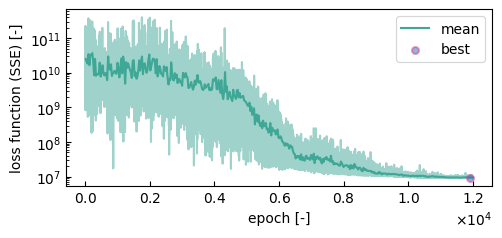

In [25]:
fig = plt.figure(figsize=[5.5, 2.3], dpi=100, facecolor="white")
palette = sns.color_palette("tab10")
marker_list = ["o", "s", "^", "x"]
make_dir(os.path.join(MAIN_DIR, TRAINING_NAME, "plots"))
plt.style.use("default")
window = 250
colors = ["#3FA796", "#FF7F3F", "#F24A72"]
with plt.style.context("./mpl_style.mplstyle"):
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    ax0 = fig.add_subplot(spec[0])
    # ax0_twin = ax0.twinx()
    ax0.set_zorder(1)
    ax0.patch.set_visible(False)
    # ax0_twin.patch.set_visible(True)
    N = len(train_i.keys())
    palette_2 = sns.color_palette("Reds", n_colors=N)
    # ax1 = fig.add_subplot(spec[1])
    for i, key in enumerate(train_i.keys()):
        # Train
        train_i_ = train_i[key]
        train_y_ = train_y[key]
        train_avg_ = train_y_avg[key]
        mask = train_mask[key]
        ax0.plot(train_i_[mask], train_y_[mask], alpha=0.5, color=colors[i], rasterized=True)
        i_min = np.where(train_y_ == np.min(train_y_[mask]))[0]
        ax0.scatter(
            train_i_[i_min],
            train_y_[i_min],
            s=5**2,
            alpha=0.5,
            color=palette[i],
            ec="#dd3497",
            lw=1.5,
            label="best",
            zorder=10,
        )
        ax0.plot(train_avg_[0], train_avg_[1], label=f"mean", color=colors[i])
        fail_x, fail_y = block_avg(np.arange(mask.size), ~mask, window)
        # ax0_twin.plot(fail_x, fail_y*100., marker=marker_list[i], lw=1., markersize=4, color='#fb6a4a', label=f'{key} (failing rate)')
        # ax0_twin.bar(fail_x-window/N*(N-i-1) +window/N/2-window/2, fail_y*100., width=window/N, color=palette_2[i], label=f'Train {key.split("_")[1]} (failing rate)', alpha=.33)
        # # Validation
        # valid_i_ = valid_i[key]
        # valid_y_ = valid_y[key]
        # valid_avg_ = valid_y_avg[key]
        # mask = valid_mask[key]
        # ax1.scatter(valid_i_[mask], valid_y_[mask], s=4**2, label=key, alpha=.5, color=palette[i])
        # i_min =np.where( valid_y_ == np.min(valid_y_[mask]) )[0]
        # ax1.scatter(valid_i_[i_min], valid_y_[i_min], s=5**2, alpha=.75, color=palette[i], ec='#dd3497', lw=1., label='best')
        # ax1.semilogy(valid_avg_[0], valid_avg_[1], label=f'{key} (mean)', color=palette[i])
        break
    ax0.legend(loc="upper right")
    ax0.set_xlabel("epoch [-]")
    ax0.set_ylabel(r"loss function (SSE) [-]")
    ax0.set_yscale("log")
    # ax0.set_xscale("log")
    # ax1.set_ylabel(r'$ SSE =\sum_{i=1}^N\left(y_i - \hat{y}_i\right)^2$ [-]')
    # ax0.set_title('Train')
    # ax0_twin.legend(loc='upper left', bbox_to_anchor=(1.12, 0.5))
    # ax0_twin.grid(False)
    xlim = ax0.get_xlim()
    # ax0.set_xlim([-10, np.max(train_i_[mask])])
    # ax0_twin.set_xlim([-10, np.max(train_i_[mask])])
    # ylim = ax0.get_ylim()
    # ax0.set_ylim([ylim[0], 1e8])
    # ax0_twin.set_ylabel(r'failing rate [%]')
    # ax1.set_title('Test')
    fig.savefig(os.path.join("perTesi", "0-training_bond.pdf"), dpi=400, bbox_inches="tight", facecolor="none")

## PCA

In [15]:
history_df = {}
for irun in range(N):
    train_prediction_files = os.path.join(MAIN_DIR, TRAINING_NAME, f"run_{irun:02d}", "opt", "training_set_history.dat")
    print(f"{irun}: {train_prediction_files}")
    if os.path.exists(train_prediction_files):
        interface = params.ReaxParams.pickle_load(
            os.path.join(MAIN_DIR, TRAINING_NAME, f"run_{irun:02d}", f"reaxff_parameters_{SUBSET}.pkl")
        )
        resutls = get_run_history(train_prediction_files, interface, workers=4, nlines=512)
        history_df[f"run_{irun:d}"] = pd.concat(resutls, axis=0, ignore_index=True)
        del resutls

0: last_attempt/training/subset_sub1v2_bond/run_00/opt/training_set_history.dat
DONE                               █████████████████████████████████████████████████████████ 100.0%
1: last_attempt/training/subset_sub1v2_bond/run_01/opt/training_set_history.dat
DONE                               █████████████████████████████████████████████████████████ 100.0%


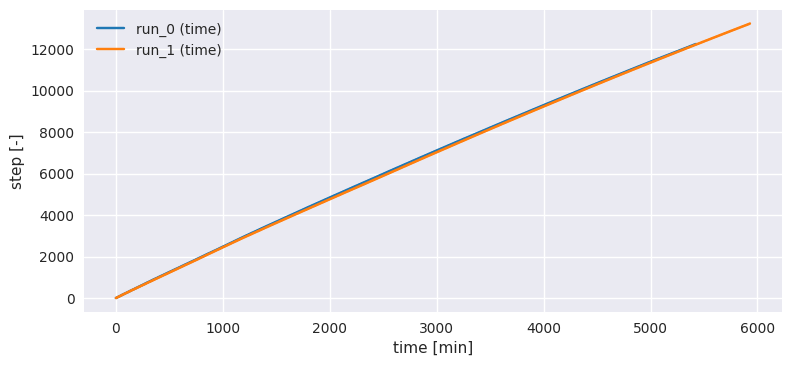

In [16]:
fig = plt.figure(figsize=[9, 4], dpi=100, facecolor="white")
palette = sns.color_palette("tab10")
with plt.style.context("seaborn"):
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    ax0 = fig.add_subplot(spec[0])
    for i, key in enumerate(history_df.keys()):
        ax0.plot(
            (history_df[key].time - history_df[key].time.min()) / 60,
            history_df[key].index,
            label=f"{key} (time)",
            color=palette[i],
        )
    ax0.legend()
    ax0.set_xlabel("time [min]")
    ax0.set_ylabel("step [-]")
    fig.savefig(
        os.path.join(MAIN_DIR, TRAINING_NAME, "plots", "supl-0-time.png"),
        dpi=300,
        bbox_inches="tight",
        facecolor="none",
    )

In [17]:
try:
    del X, y
except NameError:
    pass

x_0 = np.array(interface.x)
ranges = np.array(interface.range)
x_0_n = (x_0 - ranges[:, 1]) / (ranges[:, 0] - ranges[:, 1])

for i, key in enumerate(history_df.keys()):
    y_ = history_df[key].fx.values
    y_ = y_.astype(float)
    y_[y_ == np.inf] = np.nan

    X_ = history_df[key].iloc[:, 3:].values.astype(float).copy()
    # normalize
    for j, (lb, up) in enumerate(interface.range):
        if lb == up:
            continue
        X_[:, j] = (X_[:, j] - lb) / (up - lb)
    try:
        y = np.append(y, y_)
        X = np.append(X, X_, axis=0)
        runid = np.append(runid, np.ones(len(y_)) * i).astype("int")
    except NameError:
        y = y_.copy()
        X = X_.copy()
        runid = (np.ones(len(y_)) * i).astype("int")

    print(f"{key}: X {X.shape}; y {y.shape}")

# ADD start
X = np.append(x_0_n.reshape((1, len(x_0_n))), X, axis=0)
y = np.append(np.nanmean(y), y)

indx_best = np.where(y == y[y == y].min())

run_0: X (12256, 1267); y (12256,)
run_1: X (25500, 1267); y (25500,)


In [18]:
import itertools

from joblib import parallel_backend
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.neighbors import LocalOutlierFactor

mask = get_mask(y)
with parallel_backend("threading", n_jobs=4):
    # PCA
    # pca = PCA(n_components=2)
    pca = KernelPCA(n_components=12, kernel="rbf")
    pca.fit(X[mask, :])
    Xt = pca.transform(X)
    # # TSNE
    # tsne = TSNE(n_components=2, init='random')
    # Xtsne = tsne.fit_transform(X, y=y)
    # # Xtsne = tsne.transform(X)

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



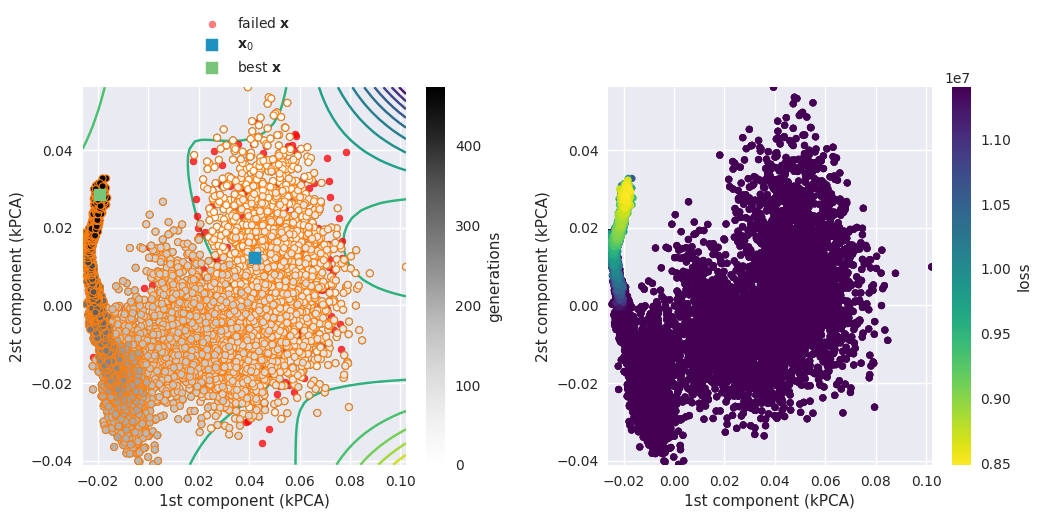

In [19]:
def polyfit2d(x, y, z, order=3):
    ncols = (order + 1) ** 2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order + 1), range(order + 1))
    for k, (i, j) in enumerate(ij):
        G[:, k] = x**i * y**j
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m


def polyval2d(x, y, m):
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order + 1), range(order + 1))
    z = np.zeros_like(x)
    for a, (i, j) in zip(m, ij):
        z += a * x**i * y**j
    return z


fig = plt.figure(figsize=[12, 5], dpi=100, facecolor="white")
PSIZE = 5**2

p0 = Xt[:, 0]
p1 = Xt[:, 1]
# p2 = Xtsne[:,0]
# p3 = Xtsne[:,1]
Z = y
sort_i = np.argsort(Z)[::-1]

# Fit a 3rd order, 2d polynomial
m = polyfit2d(p0[mask], p1[mask], Z[mask], order=3)
# m2 = polyfit2d(p2[mask],p2[mask], Z[mask], order=3)

# Evaluate it on a grid...
nx, ny = 50, 50
XX, YY = np.meshgrid(np.linspace(p0.min(), p0.max(), nx), np.linspace(p1.min(), p1.max(), ny))
ZZ = polyval2d(XX, YY, m)
levels = np.linspace(ZZ.min(), ZZ.max(), 15)

# XX_1, YY_1 = np.meshgrid(np.linspace(p2.min(), p2.max(), nx),
#                         np.linspace(p3.min(), p3.max(), ny))
# ZZ_1 = polyval2d(XX, YY, m2)
# levels_1 = np.linspace(ZZ_1.min(), ZZ_1.max(), 15)
max_gen = np.ceil(np.bincount(runid).max() / N_PARMS)
palette = sns.color_palette("tab10")
sort_mask = get_mask(Z[sort_i])

with plt.style.context("seaborn"):
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, wspace=0.3)
    ax0 = fig.add_subplot(spec[0, 0])  # , projection="3d")
    ax1 = fig.add_subplot(spec[0, 1])
    # ax2 = fig.add_subplot(spec[1,0]) #, projection="3d")
    # ax3 = fig.add_subplot(spec[1,1])
    # PCR
    ax0.contour(XX, YY, ZZ, cmap="viridis_r", levels=levels)
    n = 0
    for j, n_rid in enumerate(np.bincount(runid)):
        sc0 = ax0.scatter(
            p0[n : n + n_rid][mask[n : n + n_rid]],
            p1[n : n + n_rid][mask[n : n + n_rid]],
            s=PSIZE,
            c=np.floor(np.arange(len(y[n : n + n_rid])) / N_PARMS)[mask[n : n + n_rid]],
            cmap=plt.cm.get_cmap("Greys", max_gen),
            vmax=max_gen,
            zorder=11,
            ec=palette[j],
            lw=0.8,
        )
        n += n_rid
    fig.colorbar(sc0, ax=ax0, label="generations")
    ax0.scatter(p0[~mask], p1[~mask], s=PSIZE, c="r", zorder=10, alpha=0.5, label=r"failed $\mathbf{x}$")
    ax0.scatter(p0[0], p1[0], s=PSIZE * 3, c="#1d91c0", zorder=15, alpha=1, marker="s", label=r"$\mathbf{x}_0$")
    ax0.scatter(
        p0[indx_best],
        p1[indx_best],
        s=PSIZE * 3,
        c="#78c679",
        zorder=15,
        alpha=1,
        marker="s",
        label=r"best $\mathbf{x}$",
    )
    # ax0.scatter(p0, p1, Z)
    sc1 = ax1.scatter(
        p0[sort_i][sort_mask],
        p1[sort_i][sort_mask],
        s=PSIZE,
        c=Z[sort_i][sort_mask],
        cmap="viridis_r",
        vmax=np.quantile(y[mask], 0.25),
    )  # norm=mp.colors.LogNorm(),
    fig.colorbar(sc1, ax=ax1, label="loss")
    # # tSNE
    # ax2.contour(XX_1, YY_1, ZZ_1, cmap='viridis_r', levels=levels_1)
    # n = 0
    # for j, n_rid in enumerate(np.bincount(runid)):
    #     sc2 = ax2.scatter(p2[n:n+n_rid][mask[n:n+n_rid]], p3[n:n+n_rid][mask[n:n+n_rid]], s=PSIZE,
    #                 c=np.floor(np.arange(len(y[n:n+n_rid]))/N_PARMS)[mask[n:n+n_rid]],
    #                 cmap=plt.cm.get_cmap('Greys', max_gen), vmax=max_gen, zorder=11,
    #                 ec=palette[j], lw=.8)
    #     n += n_rid
    # fig.colorbar(sc2, ax=ax2, label='generations')
    # ax2.scatter(p2[~mask], p3[~mask], s=PSIZE, c='r', zorder=10, alpha=.5, label=r'failed $\mathbf{x}$')
    # ax2.scatter(p2[0], p3[0], s=PSIZE*3, c='#1d91c0', zorder=15, alpha=1, marker='s', label=r'$\mathbf{x}_0$')
    # ax2.scatter(p2[indx_best], p3[indx_best], s=PSIZE*3,  c='#78c679', zorder=15, alpha=1, marker='s', label=r'best $\mathbf{x}$')
    # # ax0.scatter(p0, p1, Z)
    # sc3 = ax3.scatter(p2[sort_i][sort_mask], p3[sort_i][sort_mask], s=PSIZE, c=Z[sort_i][sort_mask], cmap='viridis_r',  vmax=np.quantile(y[mask], .25)) # norm=mp.colors.LogNorm(),
    # fig.colorbar(sc3, ax=ax3, label='loss')
    for ax_ in [ax0, ax1]:
        ax_.set_xlabel("1st component (kPCA)")
        ax_.set_ylabel("2st component (kPCA)")
    # for ax_ in [ax2, ax3]:
    #     ax_.set_xlabel('1st component (tSNE)')
    #     ax_.set_ylabel('2st component (tSNE)')
    ax1.set_xlim(ax0.get_xlim())
    ax1.set_ylim(ax0.get_ylim())
    # ax3.set_xlim(ax2.get_xlim())
    # ax3.set_ylim(ax2.get_ylim())
    ax0.legend(loc="lower center", bbox_to_anchor=[0.5, 1.0])
    # ax2.legend(loc='lower center', bbox_to_anchor=[0.5, 1.])
    fig.savefig(
        os.path.join(MAIN_DIR, TRAINING_NAME, "plots", "1-reduced_space.png"),
        dpi=300,
        bbox_inches="tight",
        facecolor="none",
    )

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



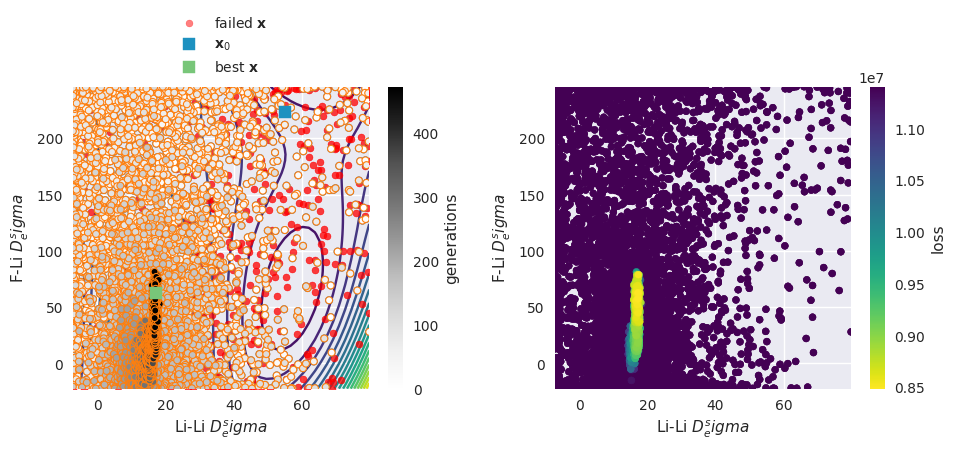

In [20]:
fig = plt.figure(figsize=[11, 4], dpi=100, facecolor="white")
PSIZE = 5**2

# x0_name = 'Li:r_0^sigma;;2;;Sigma bond covalent radius'
# x1_name = 'F:r_0^sigma;;2;;Sigma bond covalent radius'
# x0_label = r'Li $r_0^{\sigma}$ Sigma bond covalent radius [$\AA$]'
# x1_label = r'F $r_0^{\sigma}$Sigma bond covalent radius [$\AA$]'
x0_name = "Li.Li:D_e^sigma"
x1_name = "F.Li:D_e^sigma"
x0_label = r"Li-Li $D_e^sigma$"
x1_label = r"F-Li $D_e^sigma$"
mask = get_mask(y)
x0_start = interface[x0_name].value
x1_start = interface[x1_name].value

try:
    del x0, x1
except NameError:
    pass

for i, key in enumerate(history_df.keys()):
    x0_ = history_df[key].loc[:, x0_name].values.astype(float)
    x1_ = history_df[key].loc[:, x1_name].values.astype(float)
    try:
        x0 = np.append(x0, x0_)
        x1 = np.append(x1, x1_)
    except NameError:
        x0 = x0_.copy()
        x1 = x1_.copy()
x0 = np.append(x0_start, x0)
x1 = np.append(x1_start, x1)
# x0 = history_df[f'run_{irun:d}'].loc[:, x0_name].values.astype(float)
# x0 = x0
# x1 = history_df[f'run_{irun:d}'].loc[:, x1_name].values.astype(float)
# x1 = x1
Z = y[mask]
sort_i = np.argsort(y)[::-1]
sort_mask = get_mask(y[sort_i])

# Fit a 3rd order, 2d polynomial
m = polyfit2d(x0[mask], x1[mask], Z, order=3)

# Evaluate it on a grid...
nx, ny = 50, 50
XX, YY = np.meshgrid(np.linspace(x0.min(), x0.max(), nx), np.linspace(x1.min(), x1.max(), ny))
ZZ = polyval2d(XX, YY, m)
levels = np.linspace(ZZ.min(), ZZ.max(), 20)

with plt.style.context("seaborn"):
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, wspace=0.3)
    ax0 = fig.add_subplot(spec[0])  # , projection="3d")
    ax1 = fig.add_subplot(spec[1])
    ax0.contour(XX, YY, ZZ, cmap="viridis_r", levels=levels, zorder=5)
    ax0.scatter(x0[~mask], x1[~mask], s=PSIZE, c="r", zorder=10, alpha=0.5, label=r"failed $\mathbf{x}$")
    ax0.scatter(x0_start, x1_start, s=PSIZE * 3, c="#1d91c0", zorder=15, alpha=1, marker="s", label=r"$\mathbf{x}_0$")
    ax0.scatter(
        x0[indx_best],
        x1[indx_best],
        s=PSIZE * 3,
        c="#78c679",
        zorder=15,
        alpha=1,
        marker="s",
        label=r"best $\mathbf{x}$",
    )
    n = 0
    for j, n_rid in enumerate(np.bincount(runid)):
        sc0 = ax0.scatter(
            x0[n : n + n_rid][mask[n : n + n_rid]],
            x1[n : n + n_rid][mask[n : n + n_rid]],
            s=PSIZE,
            c=np.floor(np.arange(len(y[n : n + n_rid])) / N_PARMS)[mask[n : n + n_rid]],
            cmap=plt.cm.get_cmap("Greys", max_gen),
            vmax=max_gen,
            zorder=11,
            ec=palette[j],
            lw=0.8,
        )
        n += n_rid
    # sc0 = ax0.scatter(x0[mask], x1[mask], s=PSIZE, c=np.floor(np.arange(len(y))/N_PARMS)[mask],
    #                   cmap=plt.cm.get_cmap('Greys', len(y)//N_PARMS), zorder=11)
    fig.colorbar(sc0, ax=ax0, label="generations")
    sc1 = ax1.scatter(
        x0[sort_i][sort_mask],
        x1[sort_i][sort_mask],
        s=PSIZE,
        c=y[sort_i][sort_mask],
        cmap="viridis_r",
        vmax=np.quantile(y[mask], 0.25),
    )  #  norm=mp.colors.LogNorm(),
    fig.colorbar(sc1, ax=ax1, label="loss")
    ax1.set_xlim([x0.min(), x0.max()])
    ax1.set_ylim([x1.min(), x1.max()])
    for ax_ in [ax0, ax1]:
        ax_.set_xlabel(x0_label)
        ax_.set_ylabel(x1_label)
    ax1.set_xlim(ax0.get_xlim())
    ax1.set_ylim(ax0.get_ylim())
    ax0.legend(loc="lower center", bbox_to_anchor=[0.5, 1.0])
    fig.savefig(
        os.path.join(MAIN_DIR, TRAINING_NAME, "plots", "1-only_2_params.png"),
        dpi=300,
        bbox_inches="tight",
        facecolor="none",
    )

In [31]:
irun = 0
active_index = np.array(interface.is_active)
ranges = np.array(interface.range)
x_0 = np.array(interface.x)
fx = history_df[f"run_{irun:d}"].fx.values.astype("float64")
weight = np.power(fx - fx.min() + 1, -2)
x_name = history_df[f"run_{irun:d}"].columns[3:].values[active_index]
x_train = history_df[f"run_{irun:d}"].values[:, 3:].astype("float64")
x_best = (
    history_df[f"run_{irun:d}"]
    .loc[history_df[f"run_{irun:d}"].fx == history_df[f"run_{irun:d}"].fx.min()]
    .values[0, 3:]
    .astype("float64")
)
x_train_n = (x_train[:, active_index] - ranges[active_index, 0]) / (ranges[active_index, 1] - ranges[active_index, 0])
x_best_n = (x_best[active_index] - ranges[active_index, 0]) / (ranges[active_index, 1] - ranges[active_index, 0])
x_0_n = (x_0[active_index] - ranges[active_index, 0]) / (ranges[active_index, 1] - ranges[active_index, 0])

NameError: name 'history_df' is not defined

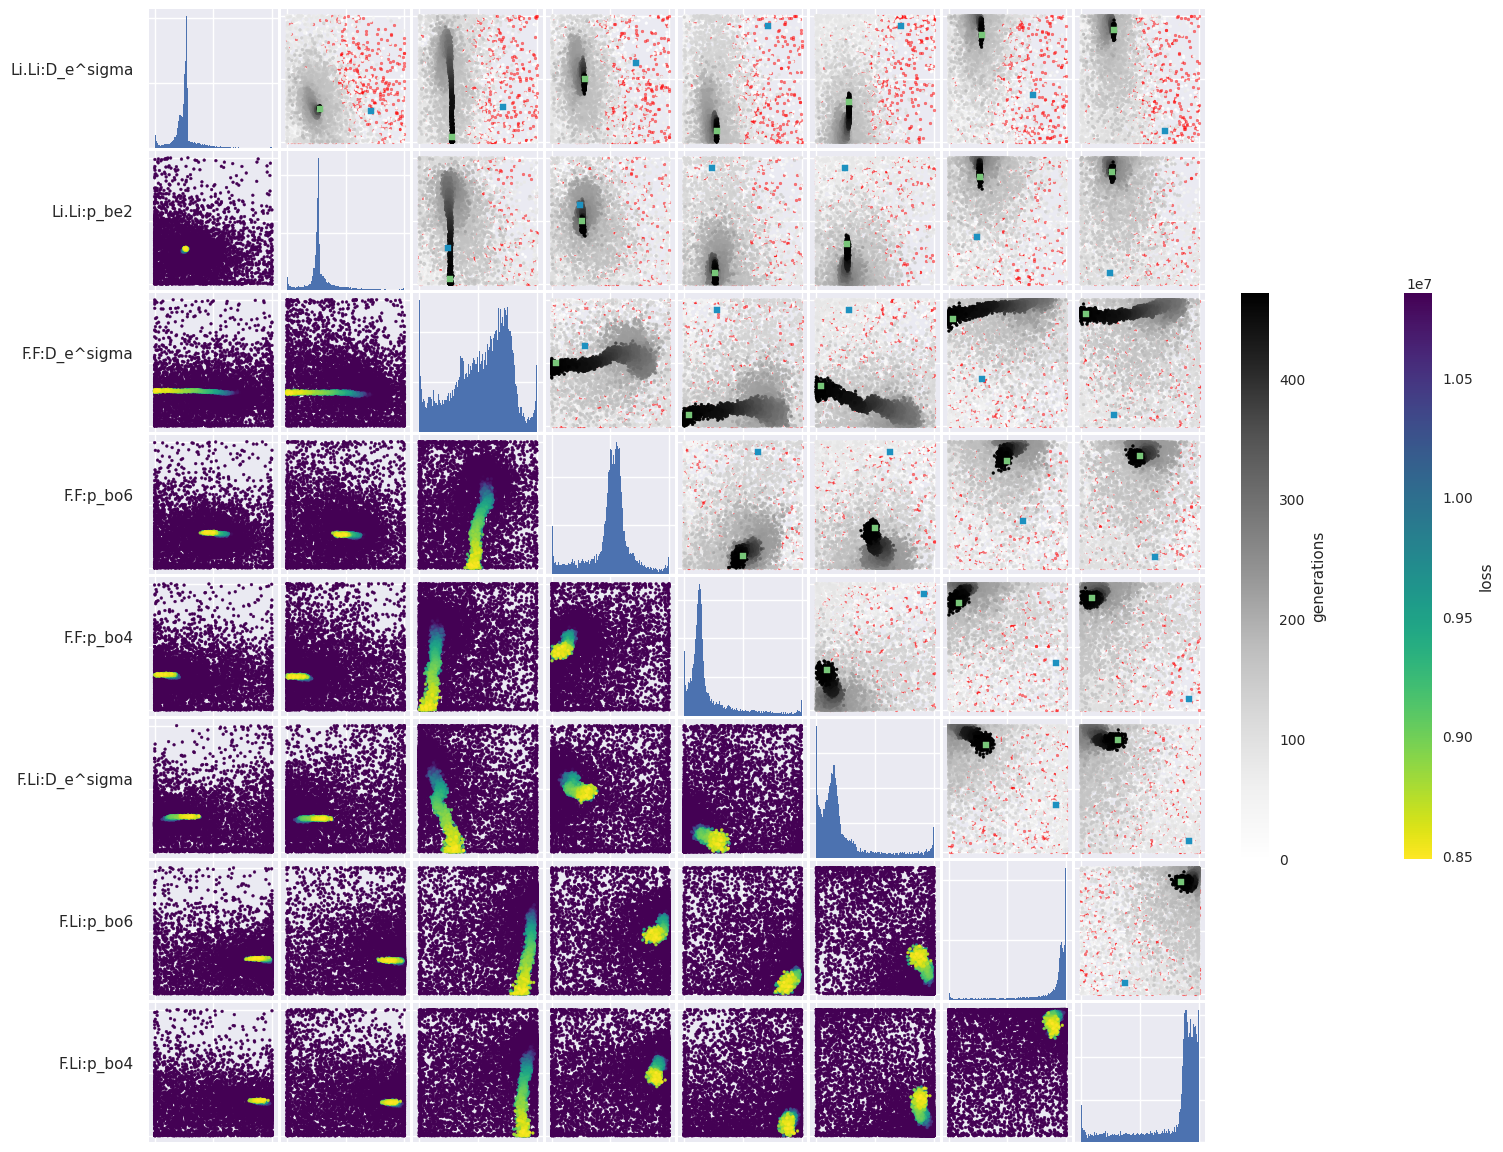

In [22]:
fig = plt.figure(figsize=[18, 15], dpi=100, facecolor="white")

axs = []
N = len(x_name)
Nstep = 4
fx[fx == np.inf] = np.nan
mask = get_mask(fx)
sort_i = np.argsort(fx)[::-1]
sort_mask = get_mask(fx[sort_i])

with plt.style.context("seaborn"):
    spec = gridspec.GridSpec(ncols=N, nrows=N, figure=fig, wspace=0.1, hspace=0.1)
    for i in range(0, N, Nstep):
        for j in range(0, N, Nstep):
            ax = fig.add_subplot(spec[i : i + Nstep, j : j + Nstep])
            axs.append(ax)
            x0 = x_train_n[:, i]
            x1 = x_train_n[:, j]
            x0_start = x_0_n[i]
            x1_start = x_0_n[j]
            x0_best = x_best_n[i]
            x1_best = x_best_n[j]
            if i == j:
                ax.hist(x0, bins=int(len(x0) ** 0.5))
                # if i ==0:
                #     ax.axes.xaxis.set_ticklabels([])
                # elif i == N-1:
                #     ax.axes.yaxis.set_ticklabels([])
                # else:
                #     ax.axes.xaxis.set_ticklabels([])
                #     ax.axes.yaxis.set_ticklabels([])
            elif i > j:
                sc1 = ax.scatter(
                    x0[sort_i][sort_mask],
                    x1[sort_i][sort_mask],
                    s=2**2,
                    c=fx[sort_i][sort_mask],
                    cmap="viridis_r",
                    vmax=np.quantile(fx[mask], 0.25),
                )  #  norm=mp.colors.LogNorm()
                # ax.scatter(x0_best, x1_best, s=3**2, c=f'#78c679', marker='s', zorder=20)
                # ax.scatter(x0_start, x1_start, s=3**2, c=f'#1d91c0', marker='s', zorder=20)
                # if j != 0:
                #     ax.axes.yaxis.set_ticklabels([])
                # if i != N-1:
                #     ax.axes.xaxis.set_ticklabels([])
            elif i < j:
                ax.scatter(x0[~mask], x1[~mask], s=2**2, c="r", zorder=10, alpha=0.5)
                sc0 = ax.scatter(
                    x0[mask],
                    x1[mask],
                    s=2**2,
                    c=np.floor(np.arange(len(fx)) / N_PARMS)[mask],
                    cmap=plt.cm.get_cmap("Greys", len(fx) // N_PARMS),
                    zorder=11,
                )
                ax.scatter(x0_best, x1_best, s=4**2, c=f"#78c679", marker="s", zorder=20)
                ax.scatter(x0_start, x1_start, s=4**2, c=f"#1d91c0", marker="s", zorder=20)
                # ax.axes.xaxis.set_ticklabels([])
                # ax.axes.yaxis.set_ticklabels([])
            if j == 0:
                ax.set_ylabel(x_name[i].split(";;")[0], rotation=0, ha="right")
            if i == N - 1:
                ax.set_xlabel(x_name[j].split(";;")[0], rotation=45, ha="right")
            ax.axes.xaxis.set_ticklabels([])
            ax.axes.yaxis.set_ticklabels([])
            # ax[-1].axis('off')
            # ax[-1].spines['right'].set_visible(False)
            # ax[-1].spines['top'].set_visible(False)
    fig.colorbar(sc1, ax=axs, label="loss", pad=0.03, shrink=0.5, anchor=(0.0, 0.5), fraction=0.1)
    fig.colorbar(sc0, ax=axs, label="generations", pad=0.03, shrink=0.5, anchor=(0.0, 0.5), fraction=0.1)
    fig.savefig(
        os.path.join(MAIN_DIR, TRAINING_NAME, "plots", f"1-run_{irun:d}-all_params.png"),
        dpi=300,
        bbox_inches="tight",
        facecolor="none",
    )

In [23]:
threshold = 0.1
tooclose_0 = np.where(x_best_n < 0 + threshold)[0]
tooclose_1 = np.where(x_best_n > 1 - threshold)[0]
print(" Too close to MIN ".center(100, "-"))
for n in tooclose_0:
    print(x_name[n])

print(" Too close to MAX ".center(100, "-"))
for n in tooclose_1:
    print(x_name[n])

----------------------------------------- Too close to MIN -----------------------------------------
Li.Li:p_bo3
F.F:D_e^sigma
F.F:p_bo4
F.Li:p_bo1
----------------------------------------- Too close to MAX -----------------------------------------
Li.Li:p_ovun1
Li.Li:p_be2
Li.Li:p_bo1
Li.Li:p_bo2
F.F:p_ovun1
F.F:p_bo3
F.Li:p_ovun1
F.Li:p_bo4


In [24]:
import statsmodels.api as sm
import weighted
from matplotlib.cbook import violin_stats
from scipy import stats


def vdensity_with_weights(weights):
    """Outer function allows innder function access to weights. Matplotlib
    needs function to take in data and coords, so this seems like only way
    to 'pass' custom density function a set of weights"""

    def vdensity(data, coords):
        """Custom matplotlib weighted violin stats function"""
        # Using weights from closure, get KDE fomr statsmodels
        weighted_cost = sm.nonparametric.KDEUnivariate(data)
        weighted_cost.fit(fft=False, weights=weights)

        # Return y-values for graph of KDE by evaluating on coords
        return weighted_cost.evaluate(coords)

    return vdensity


def custom_violin_stats(data, weights):
    # Get weighted median and mean (using weighted module for median)
    median = weighted.quantile_1D(data, weights, 0.5)
    mean, sumw = np.ma.average(data, weights=list(weights), returned=True)

    # Use matplotlib violin_stats, which expects a function that takes in data and coords
    # which we get from closure above
    results = violin_stats(data, vdensity_with_weights(weights))

    # Update result dictionary with our updated info
    results[0]["mean"] = mean
    results[0]["median"] = median

    # No need to do this, since it should be populated from violin_stats
    # results[0][u"min"] =  np.min(data)
    # results[0][u"max"] =  np.max(data)

    return results

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/weighted.py:4: DeprecationWarning:

This module has been superseded by wquantiles. In future, please import wquantiles as this module has been deprecated and will not appear in future releases.



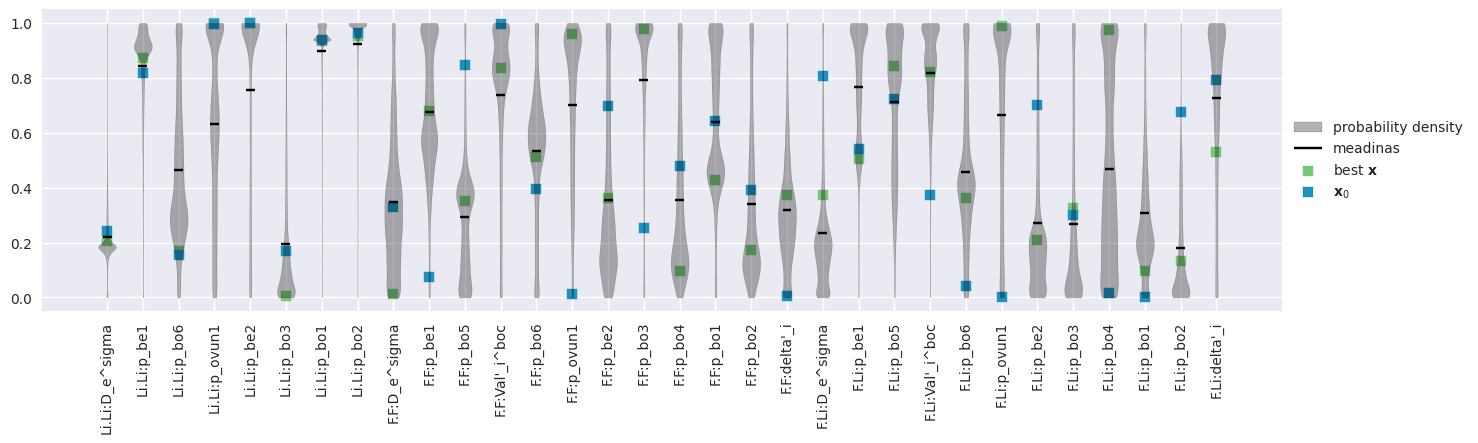

In [25]:
fig = plt.figure(figsize=[16, 4], dpi=100, facecolor="white")


with plt.style.context("seaborn"):
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, wspace=0.3)
    ax0 = fig.add_subplot(spec[0])  # , projection="3d")
    xticks_labels = x_name
    xticks = np.arange(x_name.shape[0])
    x_ind = np.arange(len(x_best_n))
    x_ind = x_ind.repeat(x_train_n.shape[0]).reshape(len(x_best_n), x_train_n.shape[0]).transpose()

    # ax0.scatter(x_ind, x_train_n, s=3**2, alpha=.02, color='k')
    poits0 = ax0.scatter(x_ind[0, :], x_best_n, s=7**2, color="#78c679", marker="s", label=r"best $\mathbf{x}$")
    poits1 = ax0.scatter(x_ind[0, :], x_0_n, s=7**2, color="#1d91c0", marker="s", label=r"$\mathbf{x}_0$")
    for j in range(0, x_train_n.shape[1], 1):
        vpstats1 = custom_violin_stats(x_train_n[:, j], np.ones(weight.shape))  #  weight)
        vplot = ax0.violin(vpstats1, vert=True, showmeans=True, showextrema=False, showmedians=False, positions=[j])
        for partname in ("cbars", "cmins", "cmaxes", "cmeans", "cmedians"):
            try:
                pc = vplot[partname]
            except Exception:
                continue
            pc.set_edgecolor("black")
        for vp in vplot["bodies"]:
            vp.set_edgecolor("black")
            vp.set_facecolor("black")
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks_labels)
    ax0.tick_params(axis="x", rotation=90)
    ax0.legend(
        [vplot["bodies"][0], vplot["cmeans"], poits0, poits1],
        ["probability density", "meadinas", r"best $\mathbf{x}$", r"$\mathbf{x}_0$"],
        loc="center left",
        bbox_to_anchor=[1.0, 0.5],
    )
    fig.savefig(
        os.path.join(MAIN_DIR, TRAINING_NAME, "plots", f"2-run_{irun:d}-violin_plot.png"),
        dpi=300,
        bbox_inches="tight",
        facecolor="none",
    )

## Sensitivitiy

In [26]:
# from emukit.core import ContinuousParameter, ParameterSpace

active_index = np.array(interface.is_active)
ranges = np.array(interface.range)
fx = history_df[f"run_{irun:d}"].fx.values.astype("float64")
weight = np.power(fx - fx.min() + 1, -2)
x_name = history_df[f"run_{irun:d}"].columns[3:].values[active_index]
x_train = history_df[f"run_{irun:d}"].values[:, 3:].astype("float64")
x_best = (
    history_df[f"run_{irun:d}"]
    .loc[history_df[f"run_{irun:d}"].fx == history_df[f"run_{irun:d}"].fx.min()]
    .values[0, 3:]
    .astype("float64")
)
x_train_n = (x_train[:, active_index] - ranges[active_index, 1]) / (ranges[active_index, 0] - ranges[active_index, 1])
x_best_n = (x_best[active_index] - ranges[active_index, 1]) / (ranges[active_index, 0] - ranges[active_index, 1])

ranges_01 = np.array([[0.0, 1.0]] * active_index.shape[0])

# space = ParameterSpace([ContinuousParameter(name, lb, ub) for name, (lb, ub) in zip(x_name, ranges_01[active_index])])

And we wrap and fit a Gaussian process to the inputs and outputs of the simulator.

In [27]:
X = x_train_n
Y = fx.reshape((fx.shape[0], 1))
ind_0, ind_1 = np.where(Y != np.inf)
X = X[ind_0, :]
Y = Y[ind_0, :]

Monte Carlo approximations to the Sobol indexes and the total variance components of each input variable of some objective of interest.

In [139]:
import time

from joblib import parallel_backend
from sklearn import gaussian_process, svm, tree
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.utils.fixes import loguniform

mask = get_mask(Y[:, 0])
regr0 = svm.SVR(C=7621.927329345217, epsilon=2.4301035606487332e-05, gamma=27.92920699803084, kernel="linear")
regr0 = make_pipeline(RobustScaler(), regr0)

# param_distributions = {
#     "kernel": [ 'linear'], #'linear', , 'sigmoid' 'rbf 'poly',
#     "C":loguniform(1e0, 1e5),
#     "gamma":loguniform(1e-6, 1e2),
#     "epsilon":loguniform(1e-7, 1e0),
# }
# regr0 = svm.SVR()
# regr0 = RandomizedSearchCV(
#     estimator=regr0,
#     param_distributions=param_distributions,
#     n_iter=1000,
#     random_state=42,
# )
# regr0 = make_pipeline(RobustScaler(), regr0)
# start_time = time.time()

# with parallel_backend('threading', n_jobs=8):
#     regr0.fit(X[mask,:], Y[mask,0])
# print(f"Time for SVR fitting: {time.time() - start_time:.3f} seconds")

regr0.fit(X[mask, :], Y[mask, 0])

# regr1 = tree.DecisionTreeRegressor(max_depth=50)
# regr1.fit(X,Y[:,0])

# kernel_ridge = KernelRidge()
# param_distributions = {
#     "alpha": loguniform(1e0, 1e8),
# }
# kernel_ridge_tuned = RandomizedSearchCV(
#     estimator=kernel_ridge,
#     param_distributions=param_distributions,
#     n_iter=100,
#     random_state=0,
# )
# start_time = time.time()
# kernel_ridge_tuned.fit(X, Y[:,0])
# print(f"Time for KernelRidge fitting: {time.time() - start_time:.3f} seconds")
regr1 = gaussian_process.GaussianProcessRegressor()
regr1.fit(X[:, :], Y[:, 0])

GaussianProcessRegressor()

In [140]:
Yp0 = regr0.predict(X)
Yp1 = regr1.predict(X)

In [141]:
# regr0['randomizedsearchcv'].best_estimator_

In [142]:
Y[:, 0].shape

(218,)

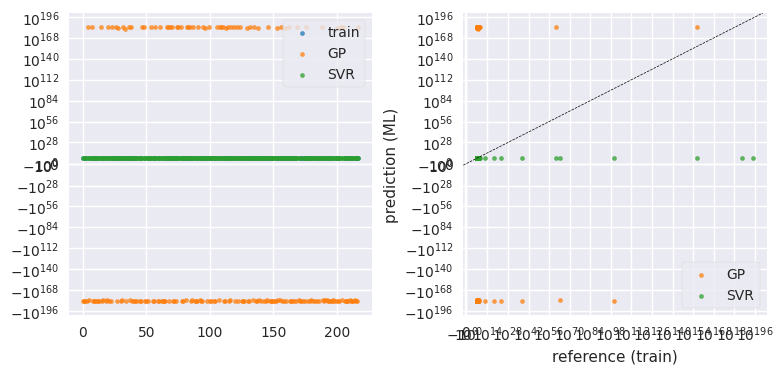

In [143]:
fig = plt.figure(figsize=[9, 4], dpi=100, facecolor="white")
palette = sns.color_palette("tab10")
mask = get_mask(Y[:, 0])
maskp0 = get_mask(Yp0)
maskp1 = get_mask(Yp1)

with plt.style.context("seaborn"):
    spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, wspace=0.3)
    ax0 = fig.add_subplot(spec[0])
    ax1 = fig.add_subplot(spec[1])
    ax1.axline([Y[0, 0], Y[0, 0]], [Y[1, 0], Y[1, 0]], color="k", ls="--", lw=0.5)
    ax0.scatter(np.arange(Y.shape[0])[mask], Y[mask, :], s=3**2, label="train", alpha=0.75, color=palette[0])
    ax0.scatter(np.arange(Y.shape[0])[maskp1], Yp1[maskp1], s=3**2, label="GP", alpha=0.75, color=palette[1])
    ax0.scatter(np.arange(Y.shape[0])[maskp0], Yp0[maskp0], s=3**2, label="SVR", alpha=0.75, color=palette[2])
    ax1.scatter(Y[maskp1, :], Yp1[maskp1], s=3**2, label="GP", alpha=0.75, color=palette[1])
    ax1.scatter(Y[maskp0, :], Yp0[maskp0], s=3**2, label="SVR", alpha=0.75, color=palette[2])
    # ax.scatter(np.arange(Y.shape[0]), Y, s=3**2, label='train', alpha=.75)
    # ax0.set_xscale("log")
    ax0.set_yscale("symlog")
    ax1.set_xscale("symlog")
    ax1.set_yscale("symlog")
    ax0.legend(frameon=True)
    ax1.legend(frameon=True)
    ax1.set_xlabel("reference (train)")
    ax1.set_ylabel("prediction (ML)")
    # ax.set_xlim([1e9, 3e10])
    # ax.set_ylim([1e9, 3e10])
    # fig.savefig(os.path.join(MAIN_DIR, TRAINING_NAME, 'plots', f'supl-1-run_{irun:d}-surrugate_model.png' ), dpi=300, bbox_inches = 'tight', facecolor='none')

In [144]:
from SALib.analyze import sobol
from SALib.sample import saltelli


def pseudo_model_0(param):
    param = np.atleast_2d(param)
    y = regr0.predict(param)
    return y


def pseudo_model_1(param):
    param = np.atleast_2d(param)
    y = regr1.predict(param)
    return y


problem = {
    "num_vars": len(x_name),
    "names": x_name.tolist(),
    "bounds": ranges_01[active_index],
}

param_values = saltelli.sample(problem, 2**8)

y0 = pseudo_model_0(param_values)
y1 = pseudo_model_1(param_values)

In [145]:
# Si_model = sobol.analyze(problem, Y[,0], calc_second_order=False)
Si_model0 = sobol.analyze(problem, y0)
Si_model1 = sobol.analyze(problem, y1)

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/numpy/core/_methods.py:205: RuntimeWarning:

overflow encountered in multiply

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/SALib/analyze/sobol.py:161: RuntimeWarning:

invalid value encountered in double_scalars

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/SALib/analyze/sobol.py:161: RuntimeWarning:

invalid value encountered in true_divide

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/SALib/analyze/sobol.py:169: RuntimeWarning:

invalid value encountered in double_scalars

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/SALib/analyze/sobol.py:169: RuntimeWarning:

invalid value encountered in true_divide

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li

In [146]:
total_Si_0, first_Si_0, second_Si_0 = Si_model0.to_df()
total_Si_1, first_Si_1, second_Si_1 = Si_model1.to_df()

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: UserWarning:




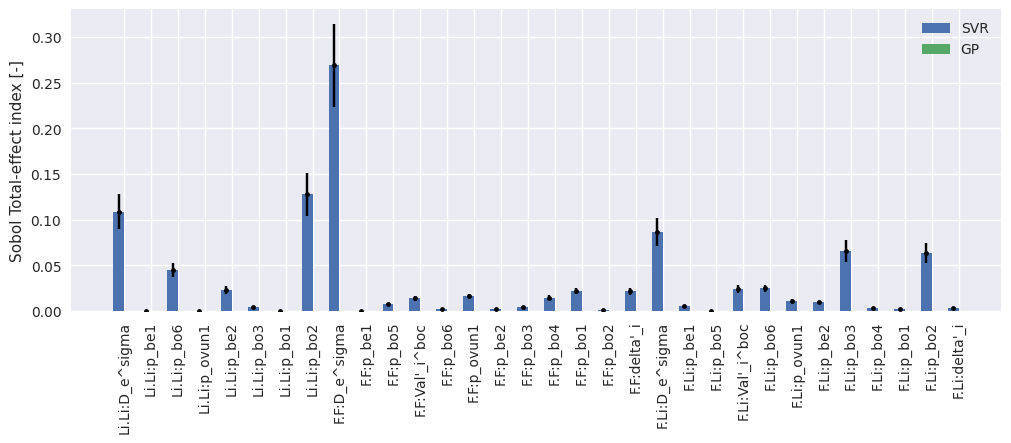

In [147]:
fig = plt.figure(figsize=[12, 4], dpi=100, facecolor="white")

with plt.style.context("seaborn"):
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    ax = fig.add_subplot(spec[0])
    xticks_labels = total_Si_0.index.values
    xticks = np.arange(xticks_labels.shape[0])
    ax.bar(xticks - 0.2, total_Si_0.ST, width=0.4, label="SVR")
    ax.bar(xticks + 0.2, total_Si_1.ST, width=0.4, label="GP")
    ax.errorbar(xticks - 0.2, total_Si_0.ST, yerr=total_Si_0.ST_conf, fmt=".k")
    ax.errorbar(xticks + 0.2, total_Si_1.ST, yerr=total_Si_1.ST_conf, fmt=".k")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks_labels)
    ax.tick_params(axis="x", rotation=90)
    ax.legend()
    ax.set_ylabel("Sobol Total-effect index [-]")
    fig.savefig(
        os.path.join(MAIN_DIR, TRAINING_NAME, "plots", f"supl-2-run_{irun:d}-sobol.png"),
        dpi=300,
        bbox_inches="tight",
        facecolor="none",
    )

## Contributions

In [15]:
irun = 0
train_prediction_files = os.path.join(
    MAIN_DIR, TRAINING_NAME, f"run_{irun:02d}", "opt", "data", "predictions", "trainingset", "*"
)
train_prediction_files = glob.glob(train_prediction_files)
train_prediction_files = np.sort(train_prediction_files)
steps = [int(path.split(os.sep)[-1].split("_")[0]) for path in train_prediction_files]
last_step = max(steps)


def loss_f(r):
    # return np.sqrt(np.sum(np.power(r, 2))/len(r))
    return np.sum(np.power(r, 2))


def loss_contribution(r, i):
    # return np.sqrt(np.power(r[i], 2)/len(r))
    return np.power(r[i], 2)


def get_predicitions(files):
    dataset_df = pd.DataFrame(
        index=np.arange(10000), columns=["expression", "sigma", "weight", "reference", "prediction", "type"]
    )

    n = 0
    for file_path in files:
        step = int(file_path.split(os.sep)[-1].split("_")[0])
        if step != last_step:
            continue
        e_type = file_path.split("_")[-1][:-4]
        with open(file_path) as file_:
            for line in file_:
                if line[0] == "#":
                    continue
                data = []
                data.append(line[:101].strip())
                data += line[101:].split()
                for j, d in enumerate(data[-5:]):
                    try:
                        dataset_df.iloc[n, j] = float(d)
                    except Exception:
                        dataset_df.iloc[n, j] = d
                dataset_df.iloc[n, -1] = e_type
                n += 1

    dataset_df = dataset_df.dropna()
    return dataset_df


dataset_df = get_predicitions(train_prediction_files)

# index = dataset_df.type == 'energy'
# dataset_df.loc[index,'sigma'] = [1e80]*sum(index) # 1e-3
# dataset_df.loc[index]
# index =  dataset_df.type == 'dihedral'
# dataset_df.loc[index,'sigma'] = [5e-1]*sum(index) # 1e-1
# dataset_df.loc[index]
# index =  dataset_df.type == 'distance'
# dataset_df.loc[index,'sigma'] = [2e-2]*sum(index) # 2e-2
# dataset_df.loc[index]
# index =  dataset_df.type == 'distance'
# dataset_df.loc[index,'weight'] = [.2]*sum(index) # 2e-2
# dataset_df.loc[index]
# index = dataset_df.type == 'forces'
# dataset_df.loc[index,'sigma'] = [5e-3]*sum(index) # 5e-3
# dataset_df.loc[index]
# index = dataset_df.type == 'forces'
# dataset_df.loc[index,'weight'] = [.2]*sum(index)  # 5e-3
# dataset_df.loc[index]
# index = dataset_df.type == 'charges'
# dataset_df.loc[index,'sigma'] = [1e-1]*sum(index) # 1.
# dataset_df.loc[index]
# index = dataset_df.type == 'angles'
# dataset_df.loc[index,'sigma'] = [1e-1]*sum(index) # 1.
# dataset_df.loc[index]
# # index = dataset_df.type == 'angles'
# # dataset_df.loc[index,'weight'] = [1e1]*sum(index) # 10.
# # dataset_df.loc[index]
# index = dataset_df.type == 'lattice'
# dataset_df.loc[index,'sigma'] = [1e-2]*sum(index) # 1e-1
# dataset_df.loc[index]


y0 = dataset_df["reference"].values.astype(float)
y = dataset_df["prediction"].values.astype(float)
w = dataset_df["weight"].values.astype(float)
s = dataset_df["sigma"].values.astype(float)
dataset_df["w_residual"] = np.abs(y - y0) * (w / s)
dataset_df["residual"] = np.abs(y - y0)
loss = loss_f(dataset_df["w_residual"].values)
dataset_df["contributions"] = [
    loss_contribution(dataset_df["w_residual"].values, idx) for idx in range(len(dataset_df["w_residual"].values))
]
dataset_df["contributions"] = dataset_df["contributions"] / dataset_df["contributions"].sum()

ValueError: max() arg is an empty sequence

In [ ]:
dataset_df.sort_values("contributions", axis=0, ascending=False).head(15)

expression  sigma weight  \
744  energy('SP-2.34-0-LiF_Fm-3m_-3.18_xxyyzz_0.115...  0.002     25   
748  energy('SP-2.38-0-LiF_Fm-3m_-3.18_xxyyzz_0.235...  0.002     25   
745  energy('SP-2.35-0-LiF_Fm-3m_-3.18_xxyyzz_0.145...  0.002     25   
743  energy('SP-2.33-0-LiF_Fm-3m_-3.18_xxyyzz_0.085...  0.002     25   
856  energy('SP-7.0-0-LiF_Fm-3m_-3.18_3x3x3_400.0ps...  0.002      1   
852  energy('SP-7.0-0-LiF_Fm-3m_-3.18_3x3x3_320.0ps...  0.002      1   
857  energy('SP-7.0-0-LiF_Fm-3m_-3.18_3x3x3_420.0ps...  0.002      1   
740  energy('SP-2.30-0-LiF_Fm-3m_-3.18_xxyyzz_-0.00...  0.002     25   
853  energy('SP-7.0-0-LiF_Fm-3m_-3.18_3x3x3_340.0ps...  0.002      1   
858  energy('SP-7.0-0-LiF_Fm-3m_-3.18_3x3x3_440.0ps...  0.002      1   
802          -energy('SP-1.5-0-LiF_Fm-3m_-3.18_3x3x3')  0.002      1   
774  energy('SP-2.26-1-LiF_P6_3mc_-3.17_xxyyzz_-0.1...  0.002   6.25   
860  energy('SP-7.0-0-LiF_Fm-3m_-3.18_3x3x3_480.0ps...  0.002      1   
859  energy('SP-7.0-0-LiF_Fm-3m_-3.18_3x3x3_460.0ps...  0.002      1   
855  energy('SP-7.0-0-LiF_Fm-3m_-3.18_3x3x3_380.0ps...  0.002      1   

     reference prediction    type  w_residual  residual  contributions  
744    0.09398       0.18  energy    1075.250  0.086020       0.134453  
748       0.25     0.1908  energy     740.000  0.059200       0.063682  
745     0.1258     0.1803  energy     681.250  0.054500       0.053972  
743     0.0595    0.01413  energy     567.125  0.045370       0.037403  
856      1.751     0.7863  energy     482.350  0.964700       0.027057  
852      1.692     0.7628  energy     464.600  0.929200       0.025102  
857      1.583     0.6806  energy     451.200  0.902400       0.023675  
740 -0.0006016   -0.03566  energy     438.230  0.035058       0.022334  
853      1.616     0.7461  energy     434.950  0.869900       0.022000  
858      1.627     0.7873  energy     419.850  0.839700       0.020499  
802     0.9247     0.1172  energy     403.750  0.807500       0.018957  
774     0.4547     0.3265  energy     400.625  0.128200       0.018665  
860      1.542     0.7507  energy     395.650  0.791300       0.018204  
859       1.48      0.707  energy     386.500  0.773000       0.017372  
855      1.538     0.7689  energy     384.550  0.769100       0.017197

In [ ]:
dataset_df["type"].unique()

array(['angles', 'charges', 'dihedral', 'distance', 'energy', 'forces', 'hessian', 'lattice', 'compared',
       'stresstensor'], dtype=object)

In [ ]:
print(f"{loss_f((y-y0) * w/s):e}")

8.598982e+06


In [ ]:
cmap_inner = mp.cm.get_cmap("bone")
inner_color = cmap_inner(np.arange(10) / 10)
cmap = mp.cm.get_cmap("tab10")
outer_color = cmap(np.arange(10))

entry_type_label = []
entry_type_count = []
entry_type_colors = []
system_label = []
system_count = []
system_colors = []
# system_names = dataset_df['systems_name'].unique()
max_n = 5

for i, entry_type in enumerate(dataset_df["type"].unique()):
    sub_df = dataset_df.loc[dataset_df["type"] == entry_type]
    entry_type_label.append(entry_type)
    entry_type_count.append(sub_df["contributions"].sum())
    entry_type_colors.append(outer_color[i].tolist())
    n_ent = len(sub_df["expression"])
    sorted_df = sub_df.sort_values("contributions", axis=0, ascending=False)
    sorted_df = sorted_df.reset_index(drop=True)
    if n_ent > max_n:
        for j in range(max_n):
            system_label.append(sorted_df.loc[j, "expression"])
            system_count.append(sorted_df.loc[j, "contributions"])
            system_colors.append(inner_color[j].tolist())
        system_count.append(entry_type_count[-1] - sum(system_count[-max_n:]))
        system_colors.append(inner_color[max_n].tolist())
        system_label.append("others")
    else:
        for j in range(n_ent):
            system_label.append(sorted_df.loc[j, "expression"])
            system_count.append(sorted_df.loc[j, "contributions"])
            system_colors.append(inner_color[j].tolist())

    # for j, systems_name in enumerate(sub_df['systems_name'].unique()):
    #     sub_sub_df = sub_df.loc[sub_df['systems_name'] == systems_name]
    #     system_label.append(systems_name)
    #     system_count.append(len(sub_sub_df))
    #     nc = np.where(system_names == systems_name)[0][0]
    #     system_colors.append(inner_color[nc].tolist() )

In [ ]:
for i, entry_type in enumerate(dataset_df["type"].unique()):
    print(
        f"{entry_type}".ljust(20, " ")
        + f"{entry_type_count[i]}".ljust(25, " ")
        + f" {entry_type_count[i]/sum(entry_type_count)*100} %"
    )

angles              0.013079527170620841      1.3079527170620842 %
charges             5.318254082580021e-07     5.318254082580021e-05 %
dihedral            0.0014059953698803338     0.14059953698803337 %
distance            5.4980485773929795e-05    0.005498048577392979 %
energy              0.973382837145726         97.33828371457261 %
forces              0.00017988608494365848    0.017988608494365847 %
hessian             9.541385365824116e-09     9.541385365824115e-07 %
lattice             0.0007199689566149885     0.07199689566149885 %
compared            0.01117625954489749       1.117625954489749 %
stresstensor        3.874749180860253e-09     3.8747491808602526e-07 %


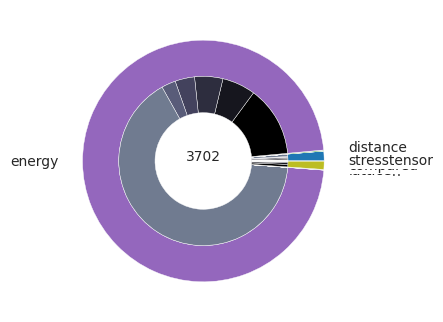

In [ ]:
fig = plt.figure(figsize=[7, 4], dpi=100, facecolor="white")

bbox_props = dict(boxstyle="square,pad=0.1", fc="w", ec="none", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")

with plt.style.context("seaborn"):
    spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig)
    ax = fig.add_subplot(spec[0])
    wedges, texts = ax.pie(
        entry_type_count,
        radius=1,  # labels=entry_type_label,
        colors=entry_type_colors,
        wedgeprops=dict(width=0.3, edgecolor="white"),
    )
    ax.pie(system_count, radius=0.7, colors=system_colors, wedgeprops=dict(width=0.3, edgecolor="white"))
    ax.annotate(f"{len(dataset_df)}", xy=(0.0, 0.0), xytext=(0.0, 0.0), horizontalalignment="center")
    # labels
    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(
            entry_type_label[i],
            xy=(x, y),
            xytext=(1.2 * np.sign(x), 1.2 * y),
            horizontalalignment=horizontalalignment,
            **kw,
        )
    fig.savefig(
        os.path.join(MAIN_DIR, TRAINING_NAME, "plots", f"supl-3-run_{irun:d}-contibutions.png"),
        dpi=300,
        bbox_inches="tight",
        facecolor="none",
    )
    # inner_patch = []
    # for i, label in enumerate(dataset_df['systems_name'].unique()):
    #     inner_patch.append( mp.patches.Patch(color=inner_color[i], label=label) )
    # ax.legend(handles=inner_patch, loc='upper left', bbox_to_anchor=(1.3, 1.))
# fig.savefig(os.path.join('plots', 'dataset_entries.png'), dpi=330, bbox_inches='tight')

# Comparisons

In [53]:
MAIN_DIR_SIM = "trainset_sim"
chem_formula = "LiF"

## Strain `Single Poin`

In [54]:
SIMsNAME = "2-Strain_SP"
RUN_DIR = os.path.join(MAIN_DIR_SIM, "2-strain_SP")
IC_DIR = "trainset_ic"
TASK = "SP"

In [55]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(IC_DIR, chem_formula, "2-strain")
data_path = os.path.join(cis_dir, "properties.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
properties_df = pd.read_json(data_path)

settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "rb") as file:
    settings = pickle.load(file)

In [56]:
def mtx2str(mtx):
    sigma_str = ["x", "y", "z"]
    strain_idx_0, strain_idx_1 = np.where(strain_mtx)
    simple_str = []
    latex_str = []
    for i0, i1 in zip(strain_idx_0, strain_idx_1):
        simple_str.append(f"ε_{sigma_str[i0]}{sigma_str[i1]}")
        latex_str.append(f"\\varepsilon_{{ {sigma_str[i0]} {sigma_str[i1]} }}")
    simple_str = " ".join(simple_str)
    latex_str = "$" + " ".join(latex_str) + "$"
    return simple_str, latex_str

In [57]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    properties_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    properties_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom
    strain_mtx = properties_df.loc[sim_name[3:] + ".cif", "strain_matrix"]
    simple_str, latex_str = mtx2str(strain_mtx)
    properties_df.loc[sim_name[3:] + ".cif", "strain_str"] = simple_str
    properties_df.loc[sim_name[3:] + ".cif", "strain_str_latex"] = latex_str
    properties_df.loc[sim_name[3:] + ".cif", "system_id"] = int(sim_name.split("-")[2])
    strain_mtx = np.array(strain_mtx)
    strain_mtx_sq = np.power(strain_mtx, 2)
    von_mises_strain = (
        2
        / 3
        * np.sign(strain_mtx.sum())
        * np.power(np.trace(strain_mtx_sq) * 3 / 2 + strain_mtx_sq[[0, 0, 1], [1, 2, 2]].sum() * 3 / 4, 1 / 2)
    )
    properties_df.loc[sim_name[3:] + ".cif", "von_mises_strain"] = von_mises_strain
properties_df.to_json(os.path.join(ALLSIM_DIR, f"results_{SIMsNAME}.json"))

In [58]:
properties_df

unitcell_repetition  \
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif                        8   
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif                        8   
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif                        8   
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif                        8   
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif                        8   
...                                                      ...   
2.34-2-LiF_Pm-3m_-2.89_xxyyzz_0.115.cif                    8   
2.35-2-LiF_Pm-3m_-2.89_xxyyzz_0.145.cif                    8   
2.36-2-LiF_Pm-3m_-2.89_xxyyzz_0.175.cif                    8   
2.37-2-LiF_Pm-3m_-2.89_xxyyzz_0.205.cif                    8   
2.38-2-LiF_Pm-3m_-2.89_xxyyzz_0.235.cif                    8   

                                                                             strain_matrix  \
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif      [[-0.125, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....   
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif      [[-0.095, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....   
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif      [[-0.065, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....   
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif      [[-0.035, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....   
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif      [[-0.005, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....   
...                                                                                    ...   
2.34-2-LiF_Pm-3m_-2.89_xxyyzz_0.115.cif  [[0.115, 0.0, 0.0], [0.0, 0.115, 0.0], [0.0, 0...   
2.35-2-LiF_Pm-3m_-2.89_xxyyzz_0.145.cif  [[0.145, 0.0, 0.0], [0.0, 0.145, 0.0], [0.0, 0...   
2.36-2-LiF_Pm-3m_-2.89_xxyyzz_0.175.cif  [[0.17500000000000002, 0.0, 0.0], [0.0, 0.1750...   
2.37-2-LiF_Pm-3m_-2.89_xxyyzz_0.205.cif  [[0.20500000000000002, 0.0, 0.0], [0.0, 0.2050...   
2.38-2-LiF_Pm-3m_-2.89_xxyyzz_0.235.cif  [[0.23500000000000001, 0.0, 0.0], [0.0, 0.2350...   

                                         scm_energy  scm_energy_per_atom  \
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif      -75.961595            -4.747600   
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif      -76.494122            -4.780883   
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif      -76.823927            -4.801495   
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif      -76.981781            -4.811361   
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif      -77.010916            -4.813182   
...                                             ...                  ...   
2.34-2-LiF_Pm-3m_-2.89_xxyyzz_0.115.cif  -69.102913            -4.318932   
2.35-2-LiF_Pm-3m_-2.89_xxyyzz_0.145.cif  -68.165433            -4.260340   
2.36-2-LiF_Pm-3m_-2.89_xxyyzz_0.175.cif  -67.159394            -4.197462   
2.37-2-LiF_Pm-3m_-2.89_xxyyzz_0.205.cif  -66.106027            -4.131627   
2.38-2-LiF_Pm-3m_-2.89_xxyyzz_0.235.cif  -65.030647            -4.064415   

                                             strain_str  \
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif                ε_xx   
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif                ε_xx   
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif                ε_xx   
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif                ε_xx   
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif                ε_xx   
...                                                 ...   
2.34-2-LiF_Pm-3m_-2.89_xxyyzz_0.115.cif  ε_xx ε_yy ε_zz   
2.35-2-LiF_Pm-3m_-2.89_xxyyzz_0.145.cif  ε_xx ε_yy ε_zz   
2.36-2-LiF_Pm-3m_-2.89_xxyyzz_0.175.cif  ε_xx ε_yy ε_zz   
2.37-2-LiF_Pm-3m_-2.89_xxyyzz_0.205.cif  ε_xx ε_yy ε_zz   
2.38-2-LiF_Pm-3m_-2.89_xxyyzz_0.235.cif  ε_xx ε_yy ε_zz   

                                                                          strain_str_latex  \
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif                                  $\varepsilon_{ x x }$   
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif                                  $\varepsilon_{ x x }$   
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif                                  $\varepsilon_{ x x }$   
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif                                  $\varepsilon_{ x x }$   
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif                

### Job Collections

In [59]:
jobcollection_test = params.JobCollection()

In [60]:
SIMsNAME = "2-Strain_SP"
jce_all = params.JCEntry()
RUN_DIR = os.path.join(SIM_DIR, "2-strain_SP")
TASK = "SP"
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "rb") as file:
    settings = pickle.load(file)

In [61]:
# Job Settings
jce_all.settings.input.AMS = settings.input.AMS.copy()
jce_all.settings.input.AMS.Properties.StressTensor = "no"
jce_all.settings

input: 	
      AMS: 	
          Properties: 	
                     ElasticTensor: 	no
                     Gradients: 	yes
                     Hessian: 	no
                     PESPointCharacter: 	no
                     StressTensor: 	no
          task: 	SinglePoint
_ipython_canary_method_should_not_exist_: 	<empty Settings>

In [62]:
cis_dir = os.path.join(IC_DIR, chem_formula, "2-strain")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, ASEtoSCM(system_ase)))

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/pymatgen/io/cif.py:1126: UserWarning:

Issues encountered while parsing CIF: Some fractional co-ordinates rounded to ideal values to avoid issues with finite precision.



In [63]:
jobs_2 = {}
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    dir_jobs = os.path.abspath(os.path.join(RUN_DIR, "jobs", sim_name))
    jce = jce_all.copy()
    if not os.path.isfile(os.path.join(dir_jobs, "ams.rkf")):
        print(f"NO ams.rkf file in {dir_jobs}")
        continue
    job = scm.AMSJob.load_external(dir_jobs, settings=jce.settings)
    # check
    if not job.check():
        print(f"Simulation {dir_jobs} FAILED")
        continue
    # job_path = os.path.join(ALLSIM_DIR, f'{sim_name}')
    jce.molecule = system_obj.copy()
    jce.molecule.lattice = []
    jce.metadata["sim_set"] = SIMsNAME
    jce.metadata["dir_job"] = dir_jobs
    jce.reference_engine = f"DFTB_{SIMsNAME}"
    jobs_2[sim_name] = scm.AMSJob.load_external(dir_jobs, settings=jce.settings)
    jobcollection_test.add_entry(sim_name, jce.copy())

In [64]:
settings_ref = scm.Settings()
settings_ref.input.AMS = settings.input.AMS.copy()
settings_ref.input.ReaxFF.ForceField = os.path.abspath("ffield.reax.CHOSiLiF_K.S.Yun_etal_2017.ff")
settings_ref

input: 	
      AMS: 	
          Properties: 	
                     ElasticTensor: 	no
                     Gradients: 	yes
                     Hessian: 	no
                     PESPointCharacter: 	no
                     StressTensor: 	no
          task: 	SinglePoint
      ReaxFF: 	
             ForceField: 	/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/0-Scipts/AMS_ReaxFF/ffield.reax.CHOSiLiF_K.S.Yun_etal_2017.ff
_ipython_canary_method_should_not_exist_: 	<empty Settings>

In [65]:
# TRAINING_NAME = 'angle_subset'
# i = 5
settings_best_1 = scm.Settings()
settings_best_1.input.AMS = settings.input.AMS.copy()
settings_best_1.input.ReaxFF.ForceField = os.path.abspath(
    os.path.join(MAIN_DIR, TRAINING_NAME, f"run_{irun:02d}", "opt", "training_set_results", "best", "ffield.ff")
)
settings_best_1

input: 	
      AMS: 	
          Properties: 	
                     ElasticTensor: 	no
                     Gradients: 	yes
                     Hessian: 	no
                     PESPointCharacter: 	no
                     StressTensor: 	no
          task: 	SinglePoint
      ReaxFF: 	
             ForceField: 	/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/0-Scipts/AMS_ReaxFF/last_attempt/training/subset_sub1v2_bond/run_00/opt/training_set_results/best/ffield.ff
_ipython_canary_method_should_not_exist_: 	<empty Settings>

In [66]:
parallel_kwargs = {"parametervectors": 1, "jobs": 10, "processes": 1, "threads": 1}
parallel = params.ParallelLevels(**parallel_kwargs)

In [67]:
results0 = jobcollection_test.run(settings_ref, parallel=parallel)

In [68]:
results1 = jobcollection_test.run(settings_best_1, parallel=parallel)

In [69]:
results = [results0, results1]

for nr, job_res in enumerate(results):
    for job_name, job_result in job_res.items():
        if not job_result.ok():
            print(f"ERROR: {job_name}")
            continue
        energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
        properties_df.loc[job_name[3:] + ".cif", f"scm_energy_{nr:d}"] = energy
        Na = len(job_result.get_main_molecule().atoms)
        if energy is None:
            energy_per_atom = np.nan
        else:
            energy_per_atom = energy / Na
        properties_df.loc[job_name[3:] + ".cif", f"scm_energy_per_atom_{nr:d}"] = energy_per_atom
#     Na = len(job_result.get_molecule('Molecule').atoms)
#     energy_per_atom = energy / Na
#     properties_df.loc[sim_name[3:] +'.cif', 'scm_energy_per_atom'] = energy_per_atom
#     strain_mtx = properties_df.loc[sim_name[3:] +'.cif', 'strain_matrix']
#     simple_str, latex_str = mtx2str(strain_mtx)
#     properties_df.loc[sim_name[3:] +'.cif', 'strain_str'] = simple_str
#     properties_df.loc[sim_name[3:] +'.cif', 'strain_str_latex'] = latex_str
#     properties_df.loc[sim_name[3:] +'.cif', 'system_id'] = int(sim_name.split('-')[2])
#     strain_mtx = np.array(strain_mtx)
#     strain_mtx_sq = np.power(strain_mtx, 2)
#     von_mises_strain = 2/3 * np.sign(strain_mtx.sum()) * np.power(np.trace(strain_mtx_sq)*3/2 + strain_mtx_sq[[0, 0, 1], [1, 2, 2]].sum()*3/4, 1/2)
#     properties_df.loc[sim_name[3:] +'.cif', 'von_mises_strain']  = von_mises_strain
# properties_df.to_json(os.path.join(ALLSIM_DIR, f'results_{SIMsNAME}.json'))

In [70]:
properties_df

unitcell_repetition  \
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif                        8   
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif                        8   
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif                        8   
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif                        8   
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif                        8   
...                                                      ...   
2.34-2-LiF_Pm-3m_-2.89_xxyyzz_0.115.cif                    8   
2.35-2-LiF_Pm-3m_-2.89_xxyyzz_0.145.cif                    8   
2.36-2-LiF_Pm-3m_-2.89_xxyyzz_0.175.cif                    8   
2.37-2-LiF_Pm-3m_-2.89_xxyyzz_0.205.cif                    8   
2.38-2-LiF_Pm-3m_-2.89_xxyyzz_0.235.cif                    8   

                                                                             strain_matrix  \
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif      [[-0.125, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....   
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif      [[-0.095, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....   
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif      [[-0.065, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....   
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif      [[-0.035, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....   
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif      [[-0.005, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0....   
...                                                                                    ...   
2.34-2-LiF_Pm-3m_-2.89_xxyyzz_0.115.cif  [[0.115, 0.0, 0.0], [0.0, 0.115, 0.0], [0.0, 0...   
2.35-2-LiF_Pm-3m_-2.89_xxyyzz_0.145.cif  [[0.145, 0.0, 0.0], [0.0, 0.145, 0.0], [0.0, 0...   
2.36-2-LiF_Pm-3m_-2.89_xxyyzz_0.175.cif  [[0.17500000000000002, 0.0, 0.0], [0.0, 0.1750...   
2.37-2-LiF_Pm-3m_-2.89_xxyyzz_0.205.cif  [[0.20500000000000002, 0.0, 0.0], [0.0, 0.2050...   
2.38-2-LiF_Pm-3m_-2.89_xxyyzz_0.235.cif  [[0.23500000000000001, 0.0, 0.0], [0.0, 0.2350...   

                                         scm_energy  scm_energy_per_atom  \
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif      -75.961595            -4.747600   
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif      -76.494122            -4.780883   
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif      -76.823927            -4.801495   
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif      -76.981781            -4.811361   
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif      -77.010916            -4.813182   
...                                             ...                  ...   
2.34-2-LiF_Pm-3m_-2.89_xxyyzz_0.115.cif  -69.102913            -4.318932   
2.35-2-LiF_Pm-3m_-2.89_xxyyzz_0.145.cif  -68.165433            -4.260340   
2.36-2-LiF_Pm-3m_-2.89_xxyyzz_0.175.cif  -67.159394            -4.197462   
2.37-2-LiF_Pm-3m_-2.89_xxyyzz_0.205.cif  -66.106027            -4.131627   
2.38-2-LiF_Pm-3m_-2.89_xxyyzz_0.235.cif  -65.030647            -4.064415   

                                             strain_str  \
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif                ε_xx   
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif                ε_xx   
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif                ε_xx   
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif                ε_xx   
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif                ε_xx   
...                                                 ...   
2.34-2-LiF_Pm-3m_-2.89_xxyyzz_0.115.cif  ε_xx ε_yy ε_zz   
2.35-2-LiF_Pm-3m_-2.89_xxyyzz_0.145.cif  ε_xx ε_yy ε_zz   
2.36-2-LiF_Pm-3m_-2.89_xxyyzz_0.175.cif  ε_xx ε_yy ε_zz   
2.37-2-LiF_Pm-3m_-2.89_xxyyzz_0.205.cif  ε_xx ε_yy ε_zz   
2.38-2-LiF_Pm-3m_-2.89_xxyyzz_0.235.cif  ε_xx ε_yy ε_zz   

                                                                          strain_str_latex  \
2.0-0-LiF_Fm-3m_-3.18_xx_-0.125.cif                                  $\varepsilon_{ x x }$   
2.1-0-LiF_Fm-3m_-3.18_xx_-0.095.cif                                  $\varepsilon_{ x x }$   
2.2-0-LiF_Fm-3m_-3.18_xx_-0.065.cif                                  $\varepsilon_{ x x }$   
2.3-0-LiF_Fm-3m_-3.18_xx_-0.035.cif                                  $\varepsilon_{ x x }$   
2.4-0-LiF_Fm-3m_-3.18_xx_-0.005.cif                

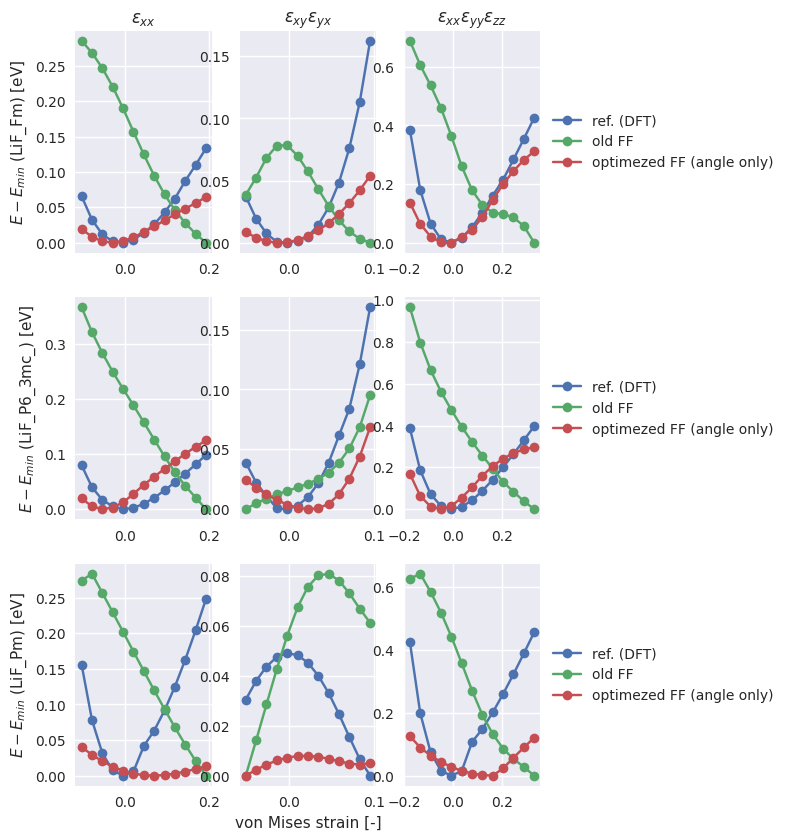

In [71]:
fig = plt.figure(figsize=[6, 10], dpi=100, facecolor="white")

results_labels = ["ref. (DFT)", "old FF", "optimezed FF (angle only)"]
results_energy = ["scm_energy_per_atom", "scm_energy_per_atom_0", "scm_energy_per_atom_1"]

with plt.style.context("seaborn"):
    ax = {}
    strain_strs = properties_df["strain_str"].dropna().unique()
    strain_strs_latex = properties_df["strain_str_latex"].dropna().unique()
    spec = gridspec.GridSpec(ncols=len(strain_strs), nrows=len(results) + 1, figure=fig)
    nRow = len(properties_df["system_id"].dropna().unique())
    for i, sim_id in enumerate(properties_df["system_id"].dropna().unique()):
        for j, (strain_str, strain_str_latex) in enumerate(zip(strain_strs, strain_strs_latex)):
            ax[i * nRow + j] = fig.add_subplot(spec[i, j])
            if i == 0:
                ax[i * nRow + j].set_title(strain_str_latex)
            sub_df = properties_df.loc[properties_df["strain_str"] == strain_str].dropna()
            idx = np.arange(len(properties_df.index))
            sub_sub_df = sub_df.loc[sub_df["system_id"] == sim_id]
            name = sub_sub_df.index[0].split("-")[2]
            for eng_key, eng_label in zip(results_energy, results_labels):
                ax[i * nRow + j].plot(
                    sub_sub_df["von_mises_strain"],
                    sub_sub_df[eng_key] - sub_sub_df[eng_key].min(),
                    "o-",
                    label=eng_label,
                )

        ax[i * nRow].set_ylabel(r"$E-E_{min}$" + f" ({name}) [eV]")
        ax[i * nRow + j].legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
        # ax[i].set_xticks(idx)
        # ax[i].set_xticklabels(properties_df.index, rotation=25, ha='right')
        # ax[i*nRow +j].set_ylim([-5, -3.8])
    ax[i * nRow + 1].set_xlabel("von Mises strain [-]")
    fig.savefig(
        os.path.join(MAIN_DIR, TRAINING_NAME, "plots", f"3-run_{irun:d}-strain_comp.png"),
        dpi=300,
        bbox_inches="tight",
        facecolor="none",
    )
plt.show()
# fig.savefig(os.path.join("plots", f"2-{chem_formula}_strains_SP.png"), dpi=300, bbox_inches='tight')

## Bonds `Single Poin`

In [ ]:
SIMsNAME = "8-Bond_SP_ADF"
RUN_DIR = os.path.join(MAIN_DIR_SIM, SIMsNAME)
IC_DIR = "trainset_ic"
TASK = "SP"

In [80]:
dir_jobs = os.path.join(RUN_DIR, "jobs")

cis_dir = os.path.join(IC_DIR, chem_formula, "8-bond")
data_path = os.path.join(cis_dir, "properties.json")
# data_path = os.path.join(ALLSIM_DIR, f'results_0-UnitCell_SP.json')
properties_df = pd.read_json(data_path)

settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "rb") as file:
    settings = pickle.load(file)

In [81]:
for job_dir in glob.glob(os.path.join(dir_jobs, "*")):
    sim_name = job_dir.split(os.sep)[-1]
    job = scm.AMSJob.load_external(job_dir, settings=settings)
    # check
    if not job.check():
        print(f"Simulation {job_dir} FAILED")
        continue
    job_result = job.results
    energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
    properties_df.loc[sim_name[3:] + ".cif", "scm_energy"] = energy
    Na = len(job_result.get_molecule("Molecule").atoms)
    energy_per_atom = energy / Na
    properties_df.loc[sim_name[3:] + ".cif", "scm_energy_per_atom"] = energy_per_atom

# properties_df.to_json(os.path.join(ALLSIM_DIR, f'results_{SIMsNAME}.json'))

In [82]:
properties_df

system  ai  aj         d  scm_energy  \
8.0-F-F-d_0.700.cif         0   F   F  0.700000   56.628797   
8.0-F-F-d_0.796.cif         0   F   F  0.796009   28.674770   
8.0-F-F-d_0.892.cif         0   F   F  0.892017   13.421483   
8.0-F-F-d_0.988.cif         0   F   F  0.988026    5.035762   
8.0-F-F-d_1.084.cif         0   F   F  1.084035    0.456825   
...                       ...  ..  ..       ...         ...   
8.2-Li-Li-d_6.035.cif       2  Li  Li  6.035423   -0.247020   
8.2-Li-Li-d_6.527.cif       2  Li  Li  6.526567   -0.159801   
8.2-Li-Li-d_7.018.cif       2  Li  Li  7.017711   -0.094370   
8.2-Li-Li-d_7.509.cif       2  Li  Li  7.508856   -0.050375   
8.2-Li-Li-d_8.000.cif       2  Li  Li  8.000000   -0.024705   

                       scm_energy_per_atom  
8.0-F-F-d_0.700.cif              28.314399  
8.0-F-F-d_0.796.cif              14.337385  
8.0-F-F-d_0.892.cif               6.710742  
8.0-F-F-d_0.988.cif               2.517881  
8.0-F-F-d_1.084.cif               0.228412  
...                                    ...  
8.2-Li-Li-d_6.035.cif            -0.123510  
8.2-Li-Li-d_6.527.cif            -0.079901  
8.2-Li-Li-d_7.018.cif            -0.047185  
8.2-Li-Li-d_7.509.cif            -0.025188  
8.2-Li-Li-d_8.000.cif            -0.012353  

[69 rows x 6 columns]

### Job Collections

In [83]:
jobcollection_test = params.JobCollection()

In [84]:
SIMsNAME = "8-Bond_SP_ADF"
jce_all = params.JCEntry()
RUN_DIR = os.path.join(SIM_DIR, SIMsNAME)
TASK = "SP"
settings_pkl_file = os.path.join(RUN_DIR, "settings.pkl")
with open(settings_pkl_file, "rb") as file:
    settings = pickle.load(file)

In [85]:
# Job Settings
jce_all.settings.input.AMS = settings.input.AMS.copy()
jce_all.settings

input: 	
      AMS: 	
          Properties: 	
                     ElasticTensor: 	no
                     Gradients: 	yes
                     Hessian: 	no
                     PESPointCharacter: 	no
                     StressTensor: 	no
          task: 	SinglePoint
_ipython_canary_method_should_not_exist_: 	<empty Settings>

In [86]:
cis_dir = os.path.join(IC_DIR, chem_formula, "8-bond")
systems = []

for path in np.sort(glob.glob(os.path.join(cis_dir, "*.cif"))):
    system_name = path.split(os.sep)[-1].split(".cif")[0]
    system_mat = Structure.from_file(path)
    system_ase = matget2ase.get_atoms(system_mat)
    systems.append((system_name, ASEtoSCM(system_ase)))

In [87]:
for name, system_obj in systems:
    sim_name = f"{TASK}-{name}"
    dir_jobs = os.path.abspath(os.path.join(RUN_DIR, "jobs", sim_name))
    jce = jce_all.copy()
    if not os.path.isfile(os.path.join(dir_jobs, "ams.rkf")):
        print(f"NO ams.rkf file in {dir_jobs}")
        continue
    job = scm.AMSJob.load_external(dir_jobs, settings=jce.settings)
    # check
    if not job.check():
        print(f"Simulation {dir_jobs} FAILED")
        continue
    # job_path = os.path.join(ALLSIM_DIR, f'{sim_name}')
    jce.molecule = system_obj.copy()
    jce.metadata["sim_set"] = SIMsNAME
    jce.metadata["dir_job"] = dir_jobs
    jce.reference_engine = f"REAXFF_{SIMsNAME}"
    # jobs_2[sim_name] = scm.AMSJob.load_external(dir_jobs, settings=jce.settings)
    jobcollection_test.add_entry(sim_name, jce.copy())

In [88]:
settings_ref = scm.Settings()
settings_ref.input.AMS = settings.input.AMS.copy()
settings_ref.input.ReaxFF.ForceField = os.path.abspath("ffield.reax.CHOSiLiF_K.S.Yun_etal_2017.ff")
settings_ref

input: 	
      AMS: 	
          Properties: 	
                     ElasticTensor: 	no
                     Gradients: 	yes
                     Hessian: 	no
                     PESPointCharacter: 	no
                     StressTensor: 	no
          task: 	SinglePoint
      ReaxFF: 	
             ForceField: 	/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/0-Scipts/AMS_ReaxFF/ffield.reax.CHOSiLiF_K.S.Yun_etal_2017.ff
_ipython_canary_method_should_not_exist_: 	<empty Settings>

In [89]:
# TRAINING_NAME = 'angle_subset'
# i = 5
settings_best_1 = scm.Settings()
settings_best_1.input.AMS = settings.input.AMS.copy()
settings_best_1.input.ReaxFF.ForceField = os.path.abspath(
    os.path.join(MAIN_DIR, TRAINING_NAME, f"run_{irun:02d}", "opt", "training_set_results", "best", "ffield.ff")
)
settings_best_1

input: 	
      AMS: 	
          Properties: 	
                     ElasticTensor: 	no
                     Gradients: 	yes
                     Hessian: 	no
                     PESPointCharacter: 	no
                     StressTensor: 	no
          task: 	SinglePoint
      ReaxFF: 	
             ForceField: 	/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/0-Scipts/AMS_ReaxFF/last_attempt/training/subset_sub1v2_bond/run_01/opt/training_set_results/best/ffield.ff
_ipython_canary_method_should_not_exist_: 	<empty Settings>

In [90]:
parallel_kwargs = {"parametervectors": 1, "jobs": 10, "processes": 1, "threads": 1}
parallel = params.ParallelLevels(**parallel_kwargs)

In [91]:
results0 = jobcollection_test.run(settings_ref, parallel=parallel)

In [92]:
results1 = jobcollection_test.run(settings_best_1, parallel=parallel)

In [93]:
results = [results0, results1]

for nr, job_res in enumerate(results):
    for job_name, job_result in job_res.items():
        energy = scm.Units.convert(job_result.get_energy(), "au", "eV")
        properties_df.loc[job_name[3:] + ".cif", f"scm_energy_{nr:d}"] = energy
        Na = len(job_result.get_molecule("Molecule").atoms)
        energy_per_atom = energy / Na
        properties_df.loc[job_name[3:] + ".cif", f"scm_energy_per_atom_{nr:d}"] = energy_per_atom
#     Na = len(job_result.get_molecule('Molecule').atoms)
#     energy_per_atom = energy / Na
#     properties_df.loc[sim_name[3:] +'.cif', 'scm_energy_per_atom'] = energy_per_atom
#     strain_mtx = properties_df.loc[sim_name[3:] +'.cif', 'strain_matrix']
#     simple_str, latex_str = mtx2str(strain_mtx)
#     properties_df.loc[sim_name[3:] +'.cif', 'strain_str'] = simple_str
#     properties_df.loc[sim_name[3:] +'.cif', 'strain_str_latex'] = latex_str
#     properties_df.loc[sim_name[3:] +'.cif', 'system_id'] = int(sim_name.split('-')[2])
#     strain_mtx = np.array(strain_mtx)
#     strain_mtx_sq = np.power(strain_mtx, 2)
#     von_mises_strain = 2/3 * np.sign(strain_mtx.sum()) * np.power(np.trace(strain_mtx_sq)*3/2 + strain_mtx_sq[[0, 0, 1], [1, 2, 2]].sum()*3/4, 1/2)
#     properties_df.loc[sim_name[3:] +'.cif', 'von_mises_strain']  = von_mises_strain
# properties_df.to_json(os.path.join(ALLSIM_DIR, f'results_{SIMsNAME}.json'))

In [94]:
properties_df

system  ai  aj         d  scm_energy  \
8.0-F-F-d_0.700.cif         0   F   F  0.700000   56.628797   
8.0-F-F-d_0.796.cif         0   F   F  0.796009   28.674770   
8.0-F-F-d_0.892.cif         0   F   F  0.892017   13.421483   
8.0-F-F-d_0.988.cif         0   F   F  0.988026    5.035762   
8.0-F-F-d_1.084.cif         0   F   F  1.084035    0.456825   
...                       ...  ..  ..       ...         ...   
8.2-Li-Li-d_6.035.cif       2  Li  Li  6.035423   -0.247020   
8.2-Li-Li-d_6.527.cif       2  Li  Li  6.526567   -0.159801   
8.2-Li-Li-d_7.018.cif       2  Li  Li  7.017711   -0.094370   
8.2-Li-Li-d_7.509.cif       2  Li  Li  7.508856   -0.050375   
8.2-Li-Li-d_8.000.cif       2  Li  Li  8.000000   -0.024705   

                       scm_energy_per_atom  scm_energy_0  \
8.0-F-F-d_0.700.cif              28.314399      6.614477   
8.0-F-F-d_0.796.cif              14.337385      3.659420   
8.0-F-F-d_0.892.cif               6.710742      1.639292   
8.0-F-F-d_0.988.cif               2.517881      0.255601   
8.0-F-F-d_1.084.cif               0.228412     -0.696629   
...                                    ...           ...   
8.2-Li-Li-d_6.035.cif            -0.123510     -0.000471   
8.2-Li-Li-d_6.527.cif            -0.079901     -0.000440   
8.2-Li-Li-d_7.018.cif            -0.047185     -0.000479   
8.2-Li-Li-d_7.509.cif            -0.025188     -0.000614   
8.2-Li-Li-d_8.000.cif            -0.012353     -0.000923   

                       scm_energy_per_atom_0  scm_energy_1  \
8.0-F-F-d_0.700.cif                 3.307239      9.741717   
8.0-F-F-d_0.796.cif                 1.829710      6.787762   
8.0-F-F-d_0.892.cif                 0.819646      4.770218   
8.0-F-F-d_0.988.cif                 0.127801      3.392158   
8.0-F-F-d_1.084.cif                -0.348314      2.450196   
...                                      ...           ...   
8.2-Li-Li-d_6.035.cif              -0.000236     -0.000471   
8.2-Li-Li-d_6.527.cif              -0.000220     -0.000440   
8.2-Li-Li-d_7.018.cif              -0.000240     -0.000479   
8.2-Li-Li-d_7.509.cif              -0.000307     -0.000614   
8.2-Li-Li-d_8.000.cif              -0.000462     -0.000923   

                       scm_energy_per_atom_1  
8.0-F-F-d_0.700.cif                 4.870859  
8.0-F-F-d_0.796.cif                 3.393881  
8.0-F-F-d_0.892.cif                 2.385109  
8.0-F-F-d_0.988.cif                 1.696079  
8.0-F-F-d_1.084.cif                 1.225098  
...                                      ...  
8.2-Li-Li-d_6.035.cif              -0.000236  
8.2-Li-Li-d_6.527.cif              -0.000220  
8.2-Li-Li-d_7.018.cif              -0.000240  
8.2-Li-Li-d_7.509.cif              -0.000307  
8.2-Li-Li-d_8.000.cif              -0.000462  

[69 rows x 10 columns]

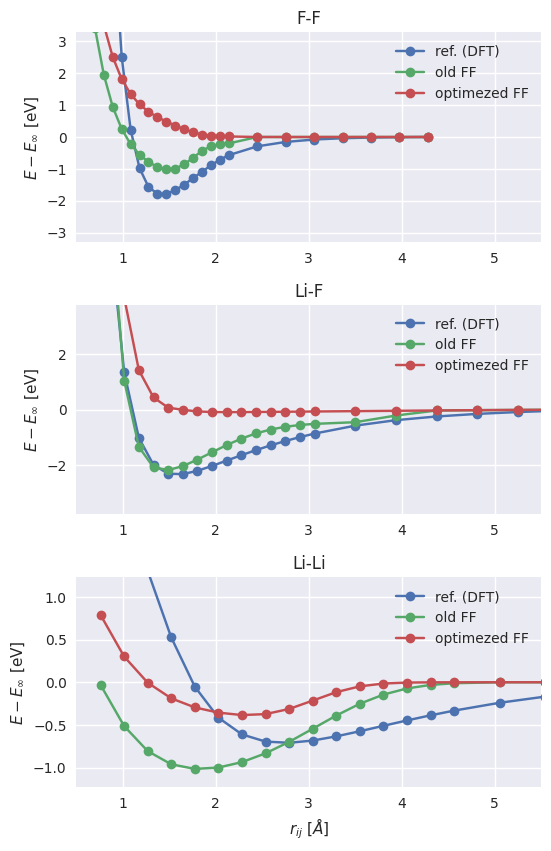

In [95]:
fig = plt.figure(figsize=[6, 10], dpi=100, facecolor="white")

results_labels = ["ref. (DFT)", "old FF", "optimezed FF"]
results_energy = ["scm_energy_per_atom", "scm_energy_per_atom_0", "scm_energy_per_atom_1"]

Nrow_max = 3
with plt.style.context("seaborn"):
    ax = []
    n_bond = len(properties_df["system"].unique())
    spec = gridspec.GridSpec(ncols=n_bond // Nrow_max, nrows=min(n_bond, Nrow_max), figure=fig, hspace=0.3)
    nRow = min(n_bond, Nrow_max)
    for i in range(n_bond):
        ax += [fig.add_subplot(spec[i])]
        sub_df = properties_df.loc[properties_df["system"] == i]
        ax[i].set_title(f"{sub_df['ai'][0]}-{sub_df['aj'][0]}")
        for j, (energy_str, energy_lbl) in enumerate(zip(results_energy, results_labels)):
            ax[i].plot(sub_df["d"], sub_df[energy_str] - sub_df[energy_str][-1], "o-", label=energy_lbl)
        ylim = ax[i].get_ylim()
        ax[i].set_ylim([ylim[0], ylim[0] * -1])
        ax[i].set_xlim([0.5, 5.5])
        ax[i].legend()
        if i // Nrow_max == 0:
            ax[i].set_ylabel(r"$E-E_{\infty}$ [eV]")
        if i == Nrow_max - 1:
            ax[i].set_xlabel(r"$r_{ij}$ [$\AA$]")

fig.savefig(
    os.path.join(MAIN_DIR, TRAINING_NAME, "plots", f"3-run_{irun:d}-bonds_comp.png"),
    dpi=300,
    bbox_inches="tight",
    facecolor="none",
)
plt.show()
# fig.savefig(os.path.join("plots", f"2-{chem_formula}_strains_SP.png"), dpi=300, bbox_inches='tight')

## All Dataset

In [96]:
irun = 0
reaxff_opt = os.path.join(MAIN_DIR, TRAINING_NAME, f"run_{irun:02d}", "opt", "trainingset_best_params")

jobcollection = params.JobCollection()
jobcollection.pickle_load(jobcollection_pickle)
dataset = params.DataSet(os.path.join(MAIN_DIR, "dataset.yaml"))
loss = params.core.lossfunctions.SSE()
interface_0 = params.ReaxParams("ffield.reax.CHOSiLiF_K.S.Yun_etal_2017.ff")
interface_1 = params.ReaxParams("ffield.reax.CHOSiLiF.optBONDS.ff")
interface_2 = params.ReaxParams(reaxff_opt)

/home/paolo/Desktop/Batteries/Tier0-C+EC-DMC+Li/venv_ams2022/AMS2022.1.venv/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning:

Pickling will be removed in a future version. Please use the yaml io instead



FileNotFoundError: last_attempt/training/subset_sub1v2_bond/run_01/opt/trainingset_best_params does not exist

In [9]:
parallel_kwargs = {"parametervectors": 1, "jobs": 10, "processes": 1, "threads": 1}
parallel = params.ParallelLevels(**parallel_kwargs)

NameError: name 'params' is not defined

In [10]:
def get_predicitions(files):
    dataset_df = pd.DataFrame(
        index=np.arange(10000), columns=["expression", "sigma", "weight", "reference", "prediction", "type"]
    )
    n = 0
    for file_path in files:
        e_type = file_path.split("_")[-1]
        with open(file_path) as file_:
            for line in file_:
                if line[0] == "#":
                    continue
                data = []
                data.append(line[:101].strip())
                data += line[101:].split()
                for j, d in enumerate(data[-5:]):
                    try:
                        dataset_df.iloc[n, j] = float(d)
                    except Exception:
                        dataset_df.iloc[n, j] = d
                dataset_df.iloc[n, -1] = e_type
                n += 1

    dataset_df = dataset_df.dropna()
    return dataset_df

### $x0$

In [83]:
engine = interface_0.get_engine()
results = jobcollection.run(
    engine.settings, jobids=dataset.jobids, parallel=parallel, use_pipe=True, _skip_normjobs=True
)

In [84]:
fx, residuals, contribution = dataset.evaluate(results, loss, return_residuals=True)

In [85]:
tmpdir = tempfile.TemporaryDirectory()

files = []
for extractor in set().union(*dataset.get("extractors")):  # all extractors that are in use
    tmp_file = os.path.join(tmpdir.name, f"pred.file_{extractor}")
    files.append(tmp_file)
    _ = dataset.get_predictions(residuals, extractors=[extractor], fpath=tmp_file)

In [86]:
dataset_0 = get_predicitions(files)
tmpdir.cleanup()

### $x1$

In [87]:
engine = interface_1.get_engine()
results = jobcollection.run(
    engine.settings, jobids=dataset.jobids, parallel=parallel, use_pipe=True, _skip_normjobs=True
)

In [88]:
fx, residuals, contribution = dataset.evaluate(results, loss, return_residuals=True)

In [89]:
tmpdir = tempfile.TemporaryDirectory()

files = []
for extractor in set().union(*dataset.get("extractors")):  # all extractors that are in use
    tmp_file = os.path.join(tmpdir.name, f"pred.file_{extractor}")
    files.append(tmp_file)
    _ = dataset.get_predictions(residuals, extractors=[extractor], fpath=tmp_file)

In [90]:
dataset_1 = get_predicitions(files)
tmpdir.cleanup()

### $x2$

In [91]:
engine = interface_2.get_engine()
results = jobcollection.run(
    engine.settings, jobids=dataset.jobids, parallel=parallel, use_pipe=True, _skip_normjobs=True
)

In [92]:
fx, residuals, contribution = dataset.evaluate(results, loss, return_residuals=True)

In [93]:
tmpdir = tempfile.TemporaryDirectory()

files = []
for extractor in set().union(*dataset.get("extractors")):  # all extractors that are in use
    tmp_file = os.path.join(tmpdir.name, f"pred.file_{extractor}")
    files.append(tmp_file)
    _ = dataset.get_predictions(residuals, extractors=[extractor], fpath=tmp_file)

In [94]:
dataset_2 = get_predicitions(files)
tmpdir.cleanup()

## Plot

In [95]:
data_name = ["old", "opt. LAST"]
datasets = [dataset_0, dataset_2]

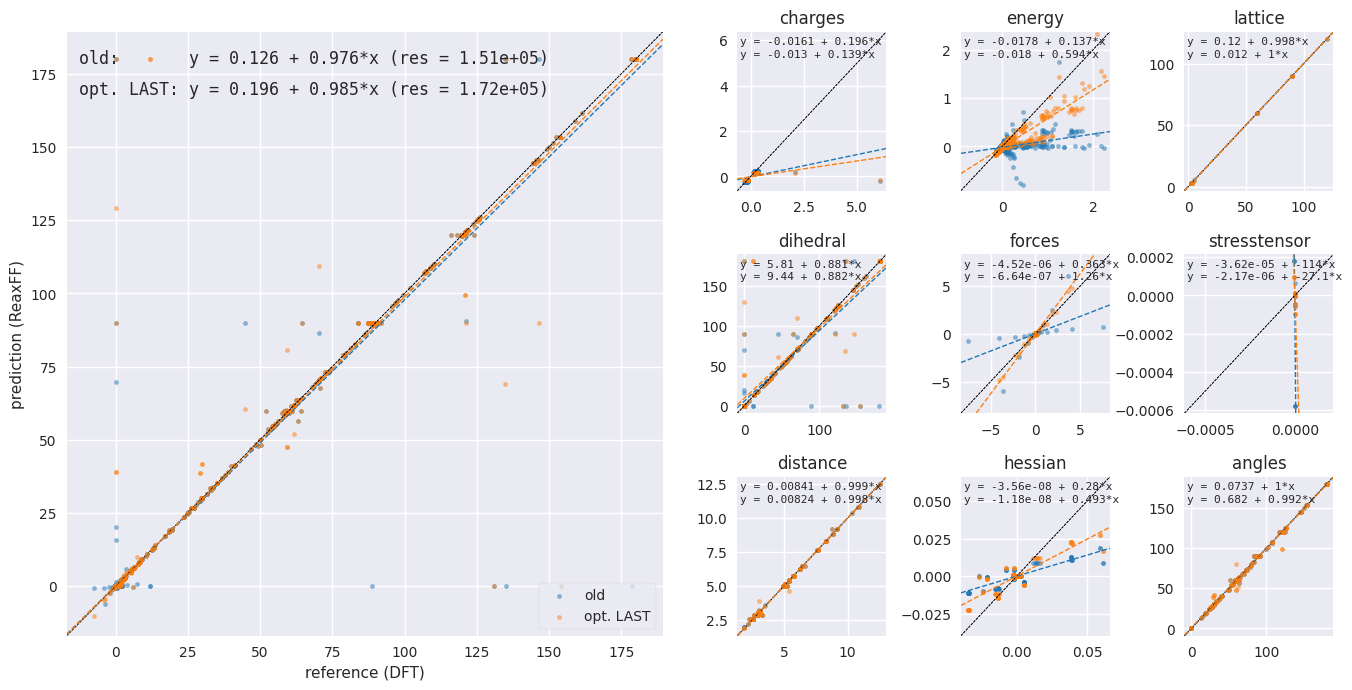

In [96]:
fig = plt.figure(figsize=[25, 8], dpi=100, facecolor="white")
from scipy.linalg import lstsq


def plot_data(dataset, ax, **kwargs):
    def retta(x, a, b):
        return b + x * a

    ax.scatter(dataset.reference, dataset.prediction, **kwargs)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.axline([0, 0], [1, 1], color="k", ls="--", lw=0.5)
    x = dataset.reference.values.astype("float")
    y = dataset.prediction.values.astype("float")
    M = x[:, np.newaxis] ** [1, 0]
    p, res, rnk, s = lstsq(M, y)
    a, b = p
    if "color" in kwargs:
        color = kwargs["color"]
    else:
        color = "r"
    ax.axline([0, retta(0, a, b)], [1, retta(1, a, b)], color=color, ls="--", lw=1)
    ax.set_xlim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])
    ax.set_ylim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])
    # ax.axis('equal')
    return a, b, res


palette = sns.color_palette("tab10")

type_dettail = np.array(
    ["charges", "dihedral", "distance", "energy", "forces", "hessian", "lattice", "stresstensor", "angles"]
)
with plt.style.context("seaborn"):
    spec = gridspec.GridSpec(nrows=3, ncols=9, figure=fig, hspace=0.4, wspace=0.5)
    axall = fig.add_subplot(spec[:3, :3])
    axs = []
    for j in range(9):
        axs.append(fig.add_subplot(spec[j % 3, 3 + j // 3]))
    for i, df in enumerate(datasets):
        a, b, res = plot_data(df, axall, s=3**2, label=data_name[i], alpha=0.5, color=palette[i])
        axall.text(
            0.02,
            0.97 - 0.05 * i,
            f'{(data_name[i]+":").ljust(10)} y = {b:1.3g} + {a:1.3g}*x (res = {res:1.3g})',
            transform=axall.transAxes,
            fontsize=12,
            va="top",
            fontfamily="monospace",
        )
        for j, e_type in enumerate(type_dettail):
            sub_df = df.loc[df.type == e_type]
            a, b, res = plot_data(sub_df, axs[j], s=3**2, label=data_name[i], alpha=0.5, color=palette[i])
            axs[j].text(
                0.02,
                0.97 - 0.08 * i,
                f"y = {b:1.3g} + {a:1.3g}*x",
                transform=axs[j].transAxes,
                fontsize=8,
                va="top",
                fontfamily="monospace",
            )
            axs[j].set_title(f"{e_type}")
        # axall.set_xscale("symlog")
        # axall.set_yscale("symlog")
        axall.legend(frameon=True, loc="lower right")
        axall.set_xlabel("reference (DFT)")
        axall.set_ylabel("prediction (ReaxFF)")
        fig.savefig(
            os.path.join(MAIN_DIR, TRAINING_NAME, "plots", f"3-run_{irun:d}-refVSpred.png"),
            dpi=300,
            bbox_inches="tight",
            facecolor="none",
        )

### Nolmalize

In [97]:
def standard_scaling(x, mu, sigma):
    return (x - mu) / sigma


for df in datasets:
    for j, e_type in enumerate(type_dettail):
        mu = np.mean(df.loc[df.type == e_type].reference.values)
        sigma = np.std(df.loc[df.type == e_type].reference.values)
        df.loc[df.type == e_type, "reference_n"] = standard_scaling(
            df.loc[df.type == e_type, "reference"].values, mu, sigma
        )
        df.loc[df.type == e_type, "prediction_n"] = standard_scaling(
            df.loc[df.type == e_type, "prediction"].values, mu, sigma
        )

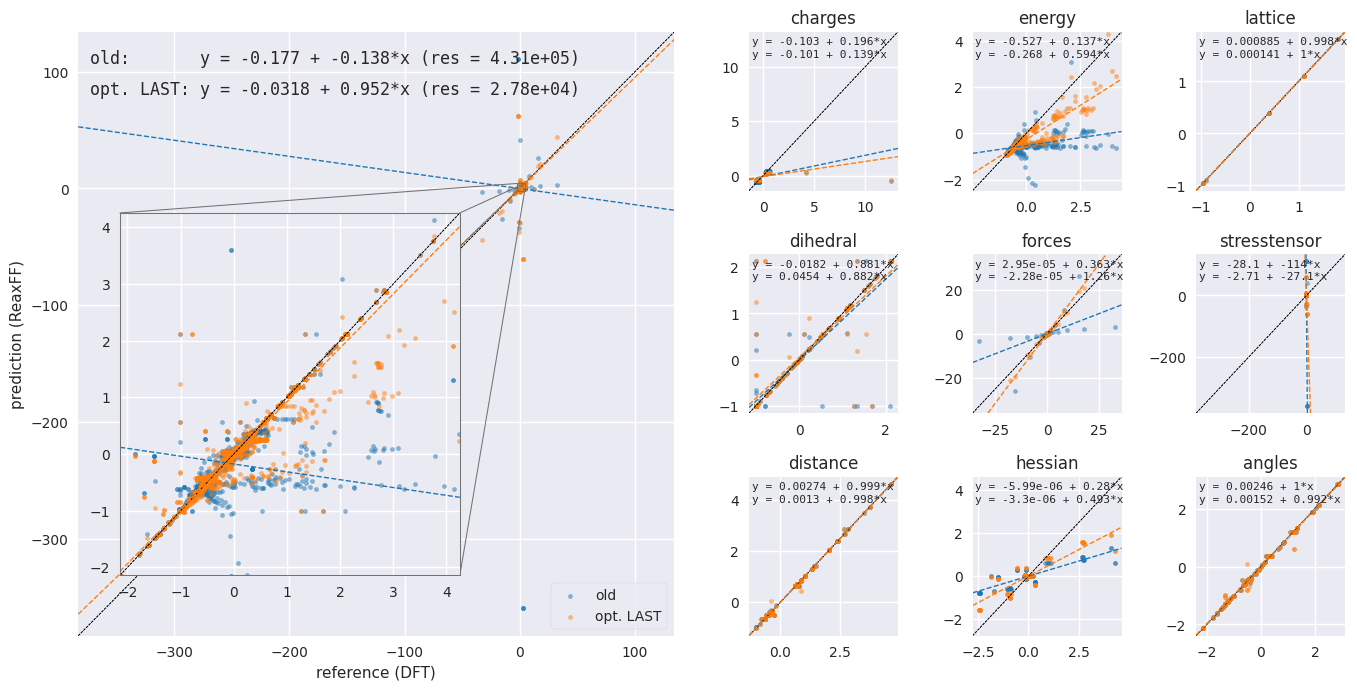

In [98]:
fig = plt.figure(figsize=[25, 8], dpi=100, facecolor="white")
from scipy.linalg import lstsq


def plot_data(dataset, ax, **kwargs):
    def retta(x, a, b):
        return b + x * a

    ax.scatter(dataset.reference_n, dataset.prediction_n, **kwargs)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.axline([0, 0], [1, 1], color="k", ls="--", lw=0.5)
    x = dataset.reference_n.values.astype("float")
    y = dataset.prediction_n.values.astype("float")
    mask = (y == y) & (x == x) & (y != np.inf) & (x != np.inf)
    # print(mask)
    x = x[mask]
    y = y[mask]
    M = x[:, np.newaxis] ** [1, 0]
    p, res, rnk, s = lstsq(M, y)
    a, b = p
    if "color" in kwargs:
        color = kwargs["color"]
    else:
        color = "r"
    ax.axline([0, retta(0, a, b)], [1, retta(1, a, b)], color=color, ls="--", lw=1)
    ax.set_xlim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])
    ax.set_ylim([min(xlim[0], ylim[0]), max(xlim[1], ylim[1])])
    # ax.axis('equal')
    return a, b, res


palette = sns.color_palette("tab10")

with plt.style.context("seaborn"):
    spec = gridspec.GridSpec(nrows=3, ncols=9, figure=fig, hspace=0.4, wspace=0.5)
    axall = fig.add_subplot(spec[:3, :3])
    axins = axall.inset_axes([0.07, 0.1, 0.57, 0.6])
    axs = []
    for j in range(9):
        axs.append(fig.add_subplot(spec[j % 3, 3 + j // 3]))
    for i, df in enumerate(datasets):
        a, b, res = plot_data(df, axall, s=3**2, label=data_name[i], alpha=0.5, color=palette[i])
        a, b, res = plot_data(df, axins, s=3**2, label=data_name[i], alpha=0.5, color=palette[i])
        axall.text(
            0.02,
            0.97 - 0.05 * i,
            f'{(data_name[i]+":").ljust(10)} y = {b:1.3g} + {a:1.3g}*x (res = {res:1.3g})',
            transform=axall.transAxes,
            fontsize=12,
            va="top",
            fontfamily="monospace",
        )
        for j, e_type in enumerate(type_dettail):
            sub_df = df.loc[df.type == e_type]
            a, b, res = plot_data(sub_df, axs[j], s=3**2, label=data_name[i], alpha=0.5, color=palette[i])
            axs[j].text(
                0.02,
                0.97 - 0.08 * i,
                f"y = {b:1.3g} + {a:1.3g}*x",
                transform=axs[j].transAxes,
                fontsize=8,
                va="top",
                fontfamily="monospace",
            )
            axs[j].set_title(f"{e_type}")
    # axall.set_xscale("symlog")
    # axall.set_yscale("symlog")
    axall.legend(frameon=True, loc="lower right")
    axall.set_xlabel("reference (DFT)")
    axall.set_ylabel("prediction (ReaxFF)")
    x = datasets[0].reference_n.values.astype("float")
    # y = datasets[0].prediction_n.values.astype('float')
    axins.set_xlim(np.quantile(x[x == x], [0.003, 0.998]))
    axins.set_ylim(np.quantile(x[x == x], [0.003, 0.998]))
    for key in ["bottom", "top", "right", "left"]:
        axins.spines[key].set_visible(True)
        axins.spines[key].set_color("#737373")
        axins.spines[key].set_linewidth(0.75)
    rec, connet = axall.indicate_inset_zoom(axins, edgecolor="#737373", linewidth=0.75, alpha=1)
    for con in connet:
        con.set_visible(True)
        con.set_color("#737373")
        con.set_linewidth(0.75)
    fig.savefig(
        os.path.join(MAIN_DIR, TRAINING_NAME, "plots", f"3-run_{irun:d}-refVSpred_norm.png"),
        dpi=300,
        bbox_inches="tight",
        facecolor="none",
    )

In [99]:
df.loc[df.type == e_type]

expression sigma   weight  \
4144  angles('GO-1.0-0-LiF_Fm-3m_-3.18_2x1x1', (1, 0...  0.01  0.06667   
4145  angles('GO-1.0-0-LiF_Fm-3m_-3.18_2x1x1', (1, 0...  0.01  0.06667   
4146  angles('GO-1.0-0-LiF_Fm-3m_-3.18_2x1x1', (0, 1...  0.01  0.06667   
4147  angles('GO-1.0-0-LiF_Fm-3m_-3.18_2x1x1', (0, 1...  0.01  0.06667   
4148  angles('GO-1.0-1-LiF_P6_3mc_-3.17_2x1x1', (2, ...  0.01  0.06667   
...                                                 ...   ...      ...   
4481  angles('GO-6.8-2-LiF_Pm-3m_-2.89_111x4', (13, ...   0.1   0.3333   
4482  angles('GO-6.8-2-LiF_Pm-3m_-2.89_111x4', (3, 5...   0.1   0.3333   
4483  angles('GO-6.8-2-LiF_Pm-3m_-2.89_111x4', (1, 4...   0.1   0.3333   
4484  angles('GO-6.8-2-LiF_Pm-3m_-2.89_111x4', (6, 1...   0.1   0.3333   
4485  angles('GO-6.8-2-LiF_Pm-3m_-2.89_111x4', (2, 4...   0.1   0.3333   

     reference prediction    type reference_n prediction_n  
4144     35.26      35.26  angles    -1.16148     -1.16148  
4145     19.47      19.47  angles     -1.5997      -1.5997  
4146        90         90  angles    0.357718     0.357718  
4147     144.7      144.7  angles     1.87581      1.87581  
4148     29.97      41.77  angles     -1.3083     -0.98081  
...        ...        ...     ...         ...          ...  
4481     88.82         90  angles     0.32497     0.357718  
4482     153.7      153.4  angles     2.12559      2.11726  
4483     89.54         90  angles    0.344952     0.357718  
4484     178.4        180  angles     2.81108      2.85549  
4485     153.7      153.4  angles     2.12559      2.11726  

[342 rows x 8 columns]

# Save Optimized

In [52]:
irun = 0
path_best = os.path.abspath(
    os.path.join(MAIN_DIR, TRAINING_NAME, f"run_{irun:02d}", "opt", "training_set_results", "best", "ffield.ff")
)
interface_best = params.ReaxParams(path_best)
interface_best.write(os.path.join("last_attempt", "ffield.reax.optimized.bond-1.v3_oldFF.ff"))